In [1]:
import numpy as np
import pandas as pd
from solve import ReactionDiffusionEquation
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re

# Table of Contents  

1. [Test case I](#test1)
    * [Exact solution](#exact1)
    * [Uniform mesh](#uniform1)
    * [Shishkin mesh](#shishkin1)
    * [Advanced finite difference scheme](#advanced1)
    * [Comparison](#comparison1)
2. [Test case II](#test2)
    * [Uniform mesh](#uniform2)
    * [Shishkin mesh](#shishkin2)
    * [Advanced finite difference scheme](#advanced2)
    * [Comparison](#comparison2)
3. [Reproduction](#reproduction)

In [2]:
save = True

## Test case I: $-\varepsilon^2 u''(x) + 4u(x) = e^{x-1}$ <a name="test1"></a>

First, we analyze the implemented methods for $-\varepsilon^2 u''(x) + 4u(x) = e^{x-1}$, $u(0)=u(1)=0$, for which a closed form solution exists.

In [3]:
# create class instance
f = lambda x: np.exp(x-1)
rde = ReactionDiffusionEquation(f=f, c=4)

### Exact solution <a name="exact1"></a>

Below we visualize the exact solution. For $\varepsilon \to 0$, boundary layers at 0 and 1 become clearly visible.

In [4]:
# def exact_solution(x, eps):
#     factor = -np.exp(2/eps + 1) + np.exp(4/eps) + np.exp(2*x/eps + x) - np.exp(4*x/eps) + np.exp((eps + 4*x + 2)/eps) - np.exp(((eps + 2)*x + 4)/eps)
#     num = np.exp(-2*x/eps - 1) * factor
#     denom = (np.exp(4/eps) - 1) * (eps - 2) * (eps + 2)
#     return num / denom

def exact_solution(x, eps):
    """
    Numerically stable version of the exact solution
    """
    num = - np.exp((-2 - 2*x)/eps) + np.exp((- 2*x)/eps - 1) - np.exp((2*x - 4)/eps - 1) + np.exp((-2 + 2*x)/eps) 
    denom = (1 - np.exp(-4/eps)) * (eps - 2) * (eps + 2)
    return num / denom - np.exp(x-1) / ((eps - 2) * (eps + 2))

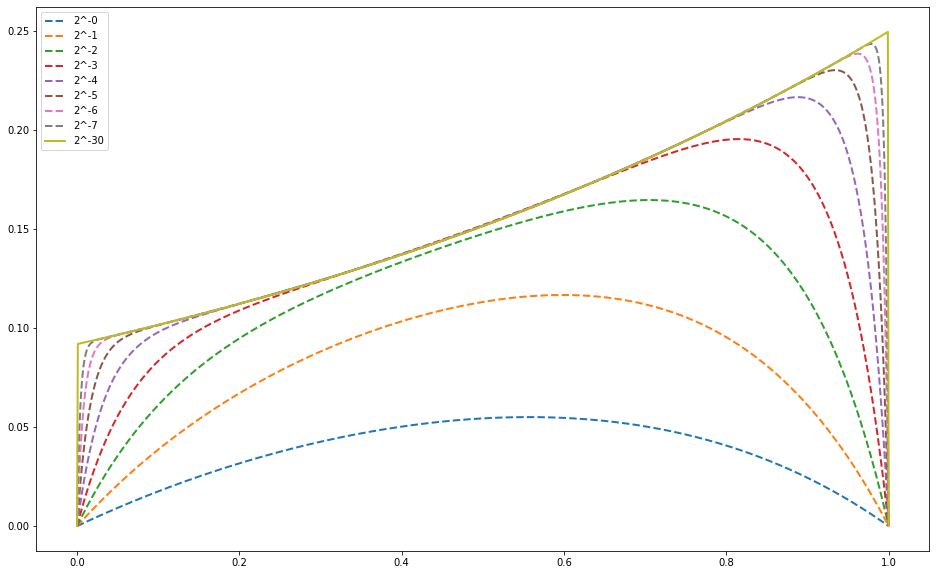

In [5]:
x = np.linspace(0, 1, 1000)
eps = np.array([2**(-k) for k in range(0, 8)])

plt.figure(figsize=(16,10))

for i, e in enumerate(eps):
    u = exact_solution(x, e)
    sns.lineplot(x=x, y=u, linewidth=2, label=f'2^-{i}', linestyle='--')

u = exact_solution(x, 2**(-30))
sns.lineplot(x=x, y=u, linewidth=2, label=f'2^-{30}')

if save:
    plt.savefig('../Resultate/test1_exact.png', bbox_inches='tight')
plt.show()

### Uniform mesh <a name="uniform1"></a>

We test our method using a uniform mesh for each combination of $\varepsilon$ and $N$, $\varepsilon = 2^{-k}$ mit $k= 0, ..., 30$ und $N=2^l$ mit $l = 4, ..., 16$. We report the pointwise maximum absolute error of our approximations over all mesh points (see the accompanying paper for details) and plot selected approximations compared to the exact solution.

In [6]:
# Calculate pointwise maximum abolute errors for each combination of N and epsilon

# define values for N and epsilon
n = np.array([2**k for k in range(4, 17)])
eps = np.array([2**(-k) for k in range(0, 31)])

results = {'eps': eps} # store results

# loop over all possible values for N
for i in n:
    # get approximations for all epsilons
    appr = rde.solve_multiple_eps(eps=eps, n=i+1, shishkin_mesh=False, sigma=2, advanced_solve=False)
    
    errors = [] # to store errors per epsilon
    for j, (x, u_appr) in enumerate(appr):

        # calculate pointwise maximum absolute error
        u = exact_solution(x=x, eps=eps[j])
        error = np.abs(u_appr - u).max()
        errors.append(error)

    results[f'N = {i}'] = errors # store results

df = pd.DataFrame(results)
df = df.set_index('eps')
if save:
    df.to_csv('../Resultate/test1_uniform.csv', index=True)
df

N = 16        N = 32        N = 64       N = 128  \
eps                                                                    
1.000000e+00  6.847682e-05  1.714165e-05  4.288203e-06  1.072203e-06   
5.000000e-01  2.778114e-04  7.007818e-05  1.753761e-05  4.385533e-06   
2.500000e-01  9.561262e-04  2.430379e-04  6.101771e-05  1.527069e-05   
1.250000e-01  3.535292e-03  9.404075e-04  2.390675e-04  6.002248e-05   
6.250000e-02  9.068193e-03  3.525073e-03  9.376881e-04  2.383762e-04   
3.125000e-02  9.355379e-03  9.061606e-03  3.522502e-03  9.370040e-04   
1.562500e-02  3.705105e-03  9.353683e-03  9.059951e-03  3.521857e-03   
7.812500e-03  9.689923e-04  3.704939e-03  9.353255e-03  9.059536e-03   
3.906250e-03  2.436656e-04  9.689823e-04  3.704897e-03  9.353148e-03   
1.953125e-03  6.100536e-05  2.436652e-04  9.689796e-04  3.704887e-03   
9.765625e-04  1.525691e-05  6.100538e-05  2.436650e-04  9.689789e-04   
4.882812e-04  3.814577e-06  1.525693e-05  6.100538e-05  2.436650e-04   
2.441406e-04  9.536659e-07  3.814581e-06  1.525693e-05  6.100537e-05   
1.220703e-04  2.384178e-07  9.536670e-07  3.814581e-06  1.525693e-05   
6.103516e-05  5.960455e-08  2.384181e-07  9.536670e-07  3.814581e-06   
3.051758e-05  1.490114e-08  5.960461e-08  2.384181e-07  9.536670e-07   
1.525879e-05  3.725286e-09  1.490116e-08  5.960462e-08  2.384181e-07   
7.629395e-06  9.313215e-10  3.725290e-09  1.490116e-08  5.960462e-08   
3.814697e-06  2.328304e-10  9.313225e-10  3.725290e-09  1.490116e-08   
1.907349e-06  5.820761e-11  2.328306e-10  9.313225e-10  3.725290e-09   
9.536743e-07  1.455189e-11  5.820766e-11  2.328306e-10  9.313225e-10   
4.768372e-07  3.637951e-12  1.455192e-11  5.820766e-11  2.328306e-10   
2.384186e-07  9.094669e-13  3.637979e-12  1.455192e-11  5.820766e-11   
1.192093e-07  2.273737e-13  9.094947e-13  3.638007e-12  1.455192e-11   
5.960464e-08  5.687117e-14  2.273737e-13  9.094947e-13  3.637979e-12   
2.980232e-08  1.421085e-14  5.684342e-14  2.273737e-13  9.094947e-13   
1.490116e-08  3.524958e-15  1.418310e-14  5.681566e-14  2.273459e-13   
7.450581e-09  8.881784e-16  3.552714e-15  1.421085e-14  5.684342e-14   
3.725290e-09  2.220446e-16  8.881784e-16  3.552714e-15  1.421085e-14   
1.862645e-09  5.551115e-17  2.220446e-16  8.881784e-16  3.552714e-15   
9.313226e-10  1.387779e-17  5.551115e-17  2.220446e-16  8.881784e-16   

                   N = 256       N = 512      N = 1024      N = 2048  \
eps                                                                    
1.000000e+00  2.680632e-07  6.701622e-08  1.675413e-08  4.188550e-09   
5.000000e-01  1.096454e-06  2.741179e-07  6.852977e-08  1.713248e-08   
2.500000e-01  3.818692e-06  9.547367e-07  2.386923e-07  5.967336e-08   
1.250000e-01  1.502172e-05  3.756438e-06  9.391726e-07  2.347973e-07   
6.250000e-02  5.984889e-05  1.497828e-05  3.745574e-06  9.364565e-07   
3.125000e-02  2.382022e-04  5.980522e-05  1.496735e-05  3.742841e-06   
1.562500e-02  9.368326e-04  2.381586e-04  5.979428e-05  1.496461e-05   
7.812500e-03  3.521696e-03  9.367897e-04  2.381477e-04  5.979154e-05   
3.906250e-03  9.059433e-03  3.521656e-03  9.367790e-04  2.381450e-04   
1.953125e-03  9.353122e-03  9.059407e-03  3.521646e-03  9.367763e-04   
9.765625e-04  3.704884e-03  9.353115e-03  9.059400e-03  3.521643e-03   
4.882812e-04  9.689787e-04  3.704883e-03  9.353113e-03  9.059399e-03   
2.441406e-04  2.436650e-04  9.689787e-04  3.704883e-03  9.353113e-03   
1.220703e-04  6.100537e-05  2.436649e-04  9.689787e-04  3.704883e-03   
6.103516e-05  1.525693e-05  6.100537e-05  2.436649e-04  9.689787e-04   
3.051758e-05  3.814581e-06  1.525693e-05  6.100537e-05  2.436649e-04   
1.525879e-05  9.536670e-07  3.814581e-06  1.525693e-05  6.100537e-05   
7.629395e-06  2.384181e-07  9.536670e-07  3.814581e-06  1.525693e-05   
3.814697e-06  5.960462e-08  2.384181e-07  9.536670e-07  3.814581e-06   
1.907349e-06  1.490116e-08  5.960462e-08  2.384181e-07  9.536670e-07   
9.536743e-07  3.725290e-09  1.490116e-08  5.960462e-08  2.3

We also compute the corresponding rates of convergence obtained as $r^N = \log_2(\frac{e^N}{e^{2N}})$ where $N$ is the number of mesh points and $e$ are the previously reported errors.

In [7]:
# compute rates of convergence
df_cr = df.apply(np.log2).diff(-1, axis=1).round(2)
if save:
    df_cr.to_csv('../Resultate/test1_uniform_convergence.csv', index=True)
df_cr

N = 16  N = 32  N = 64  N = 128  N = 256  N = 512  N = 1024  \
eps                                                                         
1.000000e+00    2.00    2.00    2.00     2.00     2.00     2.00      2.00   
5.000000e-01    1.99    2.00    2.00     2.00     2.00     2.00      2.00   
2.500000e-01    1.98    1.99    2.00     2.00     2.00     2.00      2.00   
1.250000e-01    1.91    1.98    1.99     2.00     2.00     2.00      2.00   
6.250000e-02    1.36    1.91    1.98     1.99     2.00     2.00      2.00   
3.125000e-02    0.05    1.36    1.91     1.98     1.99     2.00      2.00   
1.562500e-02   -1.34    0.05    1.36     1.91     1.98     1.99      2.00   
7.812500e-03   -1.93   -1.34    0.05     1.36     1.91     1.98      1.99   
3.906250e-03   -1.99   -1.93   -1.34     0.05     1.36     1.91      1.98   
1.953125e-03   -2.00   -1.99   -1.93    -1.34     0.05     1.36      1.91   
9.765625e-04   -2.00   -2.00   -1.99    -1.93    -1.34     0.05      1.36   
4.882812e-04   -2.00   -2.00   -2.00    -1.99    -1.93    -1.34      0.05   
2.441406e-04   -2.00   -2.00   -2.00    -2.00    -1.99    -1.93     -1.34   
1.220703e-04   -2.00   -2.00   -2.00    -2.00    -2.00    -1.99     -1.93   
6.103516e-05   -2.00   -2.00   -2.00    -2.00    -2.00    -2.00     -1.99   
3.051758e-05   -2.00   -2.00   -2.00    -2.00    -2.00    -2.00     -2.00   
1.525879e-05   -2.00   -2.00   -2.00    -2.00    -2.00    -2.00     -2.00   
7.629395e-06   -2.00   -2.00   -2.00    -2.00    -2.00    -2.00     -2.00   
3.814697e-06   -2.00   -2.00   -2.00    -2.00    -2.00    -2.00     -2.00   
1.907349e-06   -2.00   -2.00   -2.00    -2.00    -2.00    -2.00     -2.00   
9.536743e-07   -2.00   -2.00   -2.00    -2.00    -2.00    -2.00     -2.00   
4.768372e-07   -2.00   -2.00   -2.00    -2.00    -2.00    -2.00     -2.00   
2.384186e-07   -2.00   -2.00   -2.00    -2.00    -2.00    -2.00     -2.00   
1.192093e-07   -2.00   -2.00   -2.00    -2.00    -2.00    -2.00     -2.00   
5.960464e-08   -2.00   -2.00   -2.00    -2.00    -2.00    -2.00     -2.00   
2.980232e-08   -2.00   -2.00   -2.00    -2.00    -2.00    -2.00     -2.00   
1.490116e-08   -2.01   -2.00   -2.00    -2.00    -2.00    -2.00     -2.00   
7.450581e-09   -2.00   -2.00   -2.00    -2.00    -2.00    -2.00     -2.00   
3.725290e-09   -2.00   -2.00   -2.00    -2.00    -2.00    -2.00     -2.00   
1.862645e-09   -2.00   -2.00   -2.00    -2.00    -2.00    -2.00     -2.00   
9.313226e-10   -2.00   -2.00   -2.00    -2.00    -2.00    -2.00     -2.00   

              N = 2048  N = 4096  N = 8192  N = 16384  N = 32768  N = 65536  
eps                                                                          
1.000000e+00      2.00      2.00      2.01       1.53       0.31        NaN  
5.000000e-01      2.00      2.00      2.01       1.84       1.07        NaN  
2.500000e-01      2.00      2.00      2.00       2.08       2.60        NaN  
1.250000e-01      2.00      2.00      1.99       1.90       0.73        NaN  
6.250000e-02      2.00      2.00      2.00       1.99       1.89        NaN  
3.125000e-02      2.00      2.00      2.00       2.00       1.99        NaN  
1.562500e-02      2.00      2.00      2.00       2.00       2.00        NaN  
7.812500e-03      2.00      2.00      2.00       2.00       2.00        NaN  
3.906250e-03      1.99      2.00      2.00       2.00       2.00        NaN  
1.953125e-03      1.98      1.99      2.00       2.00       2.00        NaN  
9.765625e-04      1.91      1.98      1.99       2.00       2.00        NaN  
4.882812e-04      1.36      1.91      1.98       1.99       2.00        NaN  
2.441406e-04      0.05      1.36      1.91       1.98       1.99        NaN  
1.220703e-04     -1.34      0.05      1.36       1.91       1.98        NaN  
6.103516e-05     -1.93     -1.34      0.05       1.36       1.91        NaN  
3.051758e-05     -1.99     -1.93     -1.34       0.05       1.36        NaN  
1.525879e-05     -2.00     -1.99     -1.93      -1.34       0.05    

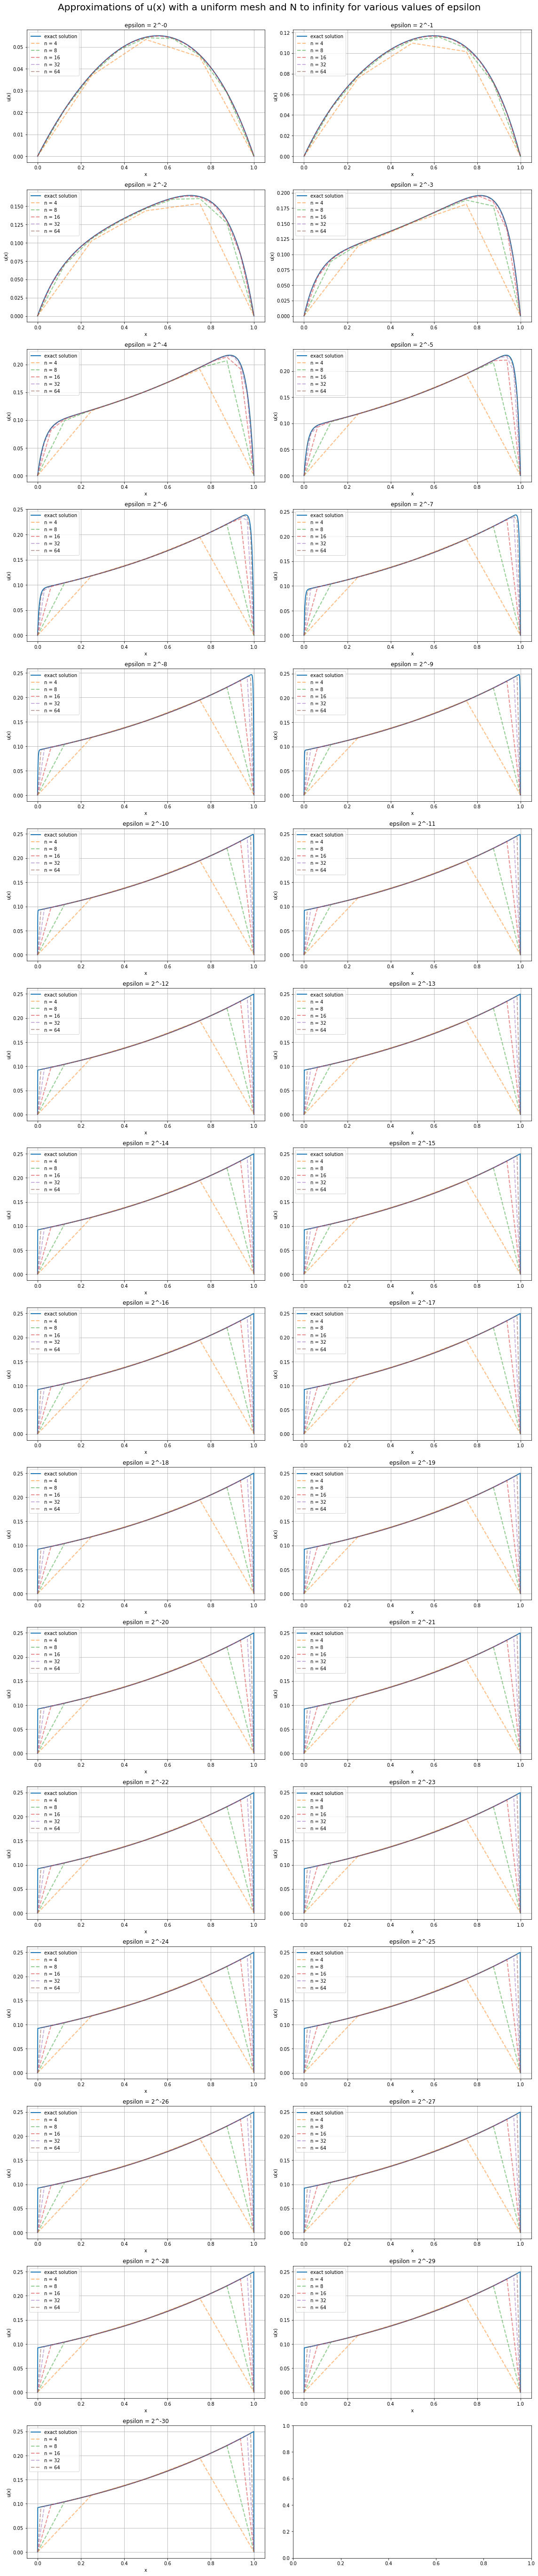

In [8]:
# Plot approximations with epsilon constant, N to infinity, for various values of epsilon

n = np.array([2**k for k in range(2, 7)]) # lower values which are still distinguishable from true solution
eps = np.array([2**(-k) for k in range(0, 31)])

# create one subplot per epsilon
height = 5 * math.ceil(len(eps)/2)
fig, axes = plt.subplots(math.ceil(len(eps)/2), 2, figsize=(16,height), tight_layout=False)
for i, (e, ax) in enumerate(zip(eps, axes.flatten())):
    # get approximations for each n
    solutions = rde.solve_multiple_n(n=n+1, eps=e, shishkin_mesh=False, sigma=2, advanced_solve=False)
    
    # exact solution
    x = np.linspace(0., 1., 1000)
    u = exact_solution(x=x, eps=e)
    sns.lineplot(x=x, y=u, linewidth=2, label=f'exact solution', ax=ax)

    # plot approximations
    for j, (x, u) in enumerate(solutions):
        sns.lineplot(x=x, y=u, linewidth=2, label=f'n = {n[j]}', alpha=0.5, linestyle='--', ax=ax)

    ax.grid()
    ax.set_title(f'epsilon = 2^-{i}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
fig.suptitle(f'Approximations of u(x) with a uniform mesh and N to infinity for various values of epsilon', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
if save:
    plt.savefig('../Resultate/test1_uniform1.png', bbox_inches='tight')
plt.show()

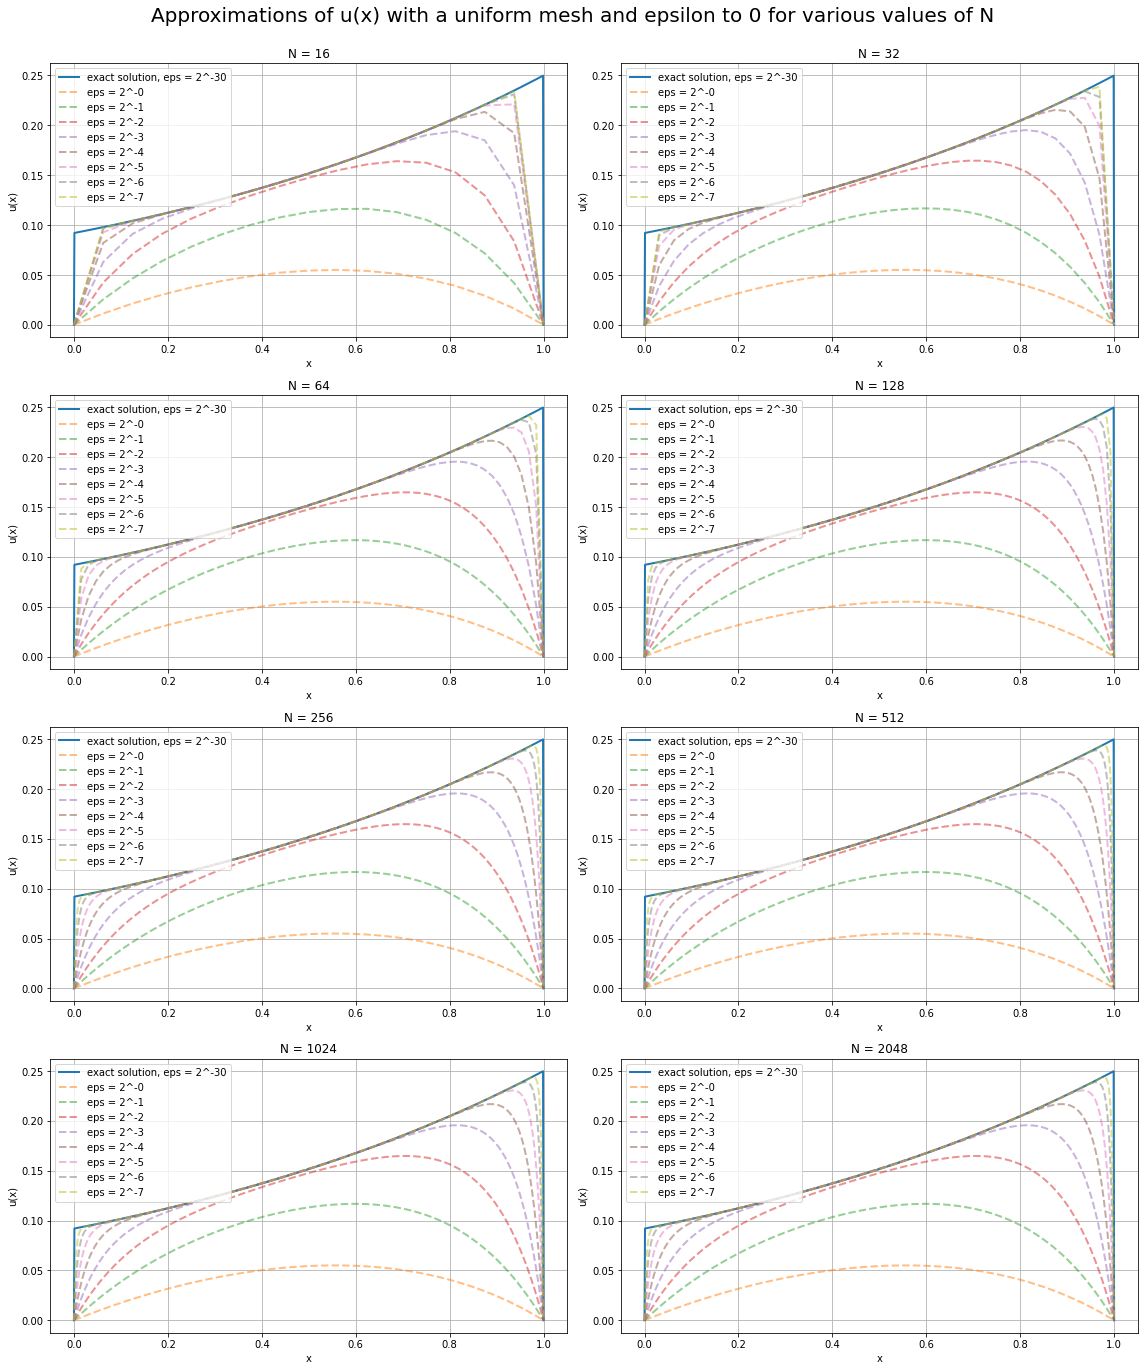

In [9]:
# Plot approximations with N constant, epsilon to 0, for various values of N

n = np.array([2**k for k in range(4, 17)])
eps = np.array([2**(-k) for k in range(0, 8)])

# create one subplot per N
height = 5 * math.ceil(len(eps)/2)
fig, axes = plt.subplots(math.ceil(len(eps)/2), 2, figsize=(16,height), tight_layout=False)
for i, (j, ax) in enumerate(zip(n, axes.flatten())):
    # get approximations for each epsilon
    solutions = rde.solve_multiple_eps(n=j+1, eps=eps, shishkin_mesh=False, sigma=2, advanced_solve=False)
    
    # exact solution
    x = np.linspace(0., 1., 1000)
    u = exact_solution(x=x, eps=2**(-30))
    sns.lineplot(x=x, y=u, linewidth=2, label=f'exact solution, eps = 2^-30', ax=ax)

    # plot approximations
    for k, (x, u) in enumerate(solutions):
        sns.lineplot(x=x, y=u, linewidth=2, label=f'eps = 2^-{k}', alpha=0.5, linestyle='--', ax=ax)

    ax.grid()
    ax.legend(loc='upper left')
    ax.set_title(f'N = {j}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
fig.suptitle(f'Approximations of u(x) with a uniform mesh and epsilon to 0 for various values of N', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
if save:
    plt.savefig('../Resultate/test1_uniform2.png', bbox_inches='tight')
plt.show()

### Shishkin mesh <a name="shishkin1"></a>

We test our method using a Shishkin mesh with the mesh parameter $\sigma=2$ for each combination of $\varepsilon$ and $N$, $\varepsilon = 2^{-k}$ mit $k= 0, ..., 30$ und $N=2^l$ mit $l = 4, ..., 16$. We report the pointwise maximum absolute error of our approximations over all mesh points and plot selected approximations compared to the exact solution.

In [10]:
# Calculate pointwise maximum abolute errors for each combination of N and epsilon

# define values for N and epsilon
n = np.array([2**k for k in range(4, 17)])
eps = np.array([2**(-k) for k in range(0, 31)])

results = {'eps': eps} # store results

# loop over all possible values for N
for i in n:
    # get approximations for all epsilons
    appr = rde.solve_multiple_eps(eps=eps, n=i+1, shishkin_mesh=True, sigma=2, advanced_solve=False)
    
    errors = [] # to store errors per epsilon
    for j, (x, u_appr) in enumerate(appr):

        # calculate pointwise maximum absolute error
        u = exact_solution(x=x, eps=eps[j])
        error = np.abs(u_appr - u).max()
        errors.append(error)

    results[f'N = {i}'] = errors # store results

df = pd.DataFrame(results)
df = df.set_index('eps')
if save:
    df.to_csv('../Resultate/test1_shishkin.csv', index=True)
df

N = 16    N = 32    N = 64   N = 128       N = 256  \
eps                                                                  
1.000000e+00  0.000068  0.000017  0.000004  0.000001  2.680632e-07   
5.000000e-01  0.000278  0.000070  0.000018  0.000004  1.096454e-06   
2.500000e-01  0.000956  0.000243  0.000061  0.000015  3.818692e-06   
1.250000e-01  0.003535  0.000940  0.000239  0.000060  1.502172e-05   
6.250000e-02  0.006039  0.002668  0.000938  0.000238  5.984889e-05   
3.125000e-02  0.006026  0.002666  0.001011  0.000348  1.146980e-04   
1.562500e-02  0.006018  0.002665  0.001010  0.000348  1.146770e-04   
7.812500e-03  0.006014  0.002665  0.001010  0.000348  1.146718e-04   
3.906250e-03  0.006012  0.002665  0.001010  0.000348  1.146704e-04   
1.953125e-03  0.006011  0.002665  0.001010  0.000348  1.146701e-04   
9.765625e-04  0.006011  0.002665  0.001010  0.000348  1.146699e-04   
4.882812e-04  0.006010  0.002665  0.001010  0.000348  1.146699e-04   
2.441406e-04  0.006010  0.002665  0.001010  0.000348  1.146699e-04   
1.220703e-04  0.006010  0.002665  0.001010  0.000348  1.146699e-04   
6.103516e-05  0.006010  0.002665  0.001010  0.000348  1.146699e-04   
3.051758e-05  0.006010  0.002665  0.001010  0.000348  1.146699e-04   
1.525879e-05  0.006010  0.002665  0.001010  0.000348  1.146699e-04   
7.629395e-06  0.006010  0.002665  0.001010  0.000348  1.146699e-04   
3.814697e-06  0.006010  0.002665  0.001010  0.000348  1.146699e-04   
1.907349e-06  0.006010  0.002665  0.001010  0.000348  1.146699e-04   
9.536743e-07  0.006010  0.002665  0.001010  0.000348  1.146699e-04   
4.768372e-07  0.006010  0.002665  0.001010  0.000348  1.146699e-04   
2.384186e-07  0.006010  0.002665  0.001010  0.000348  1.146697e-04   
1.192093e-07  0.006010  0.002665  0.001010  0.000348  1.146688e-04   
5.960464e-08  0.006010  0.002665  0.001010  0.000348  1.146721e-04   
2.980232e-08  0.006010  0.002665  0.001010  0.000348  1.146721e-04   
1.490116e-08  0.006010  0.002665  0.001010  0.000348  1.146715e-04   
7.450581e-09  0.006010  0.002665  0.001010  0.000348  1.146728e-04   
3.725290e-09  0.006010  0.002665  0.001010  0.000348  1.146701e-04   
1.862645e-09  0.006010  0.002665  0.001010  0.000348  1.146701e-04   
9.313226e-10  0.006010  0.002665  0.001010  0.000348  1.159556e-04   

                   N = 512      N = 1024      N = 2048      N = 4096  \
eps                                                                    
1.000000e+00  6.701622e-08  1.675413e-08  4.188550e-09  1.047334e-09   
5.000000e-01  2.741179e-07  6.852977e-08  1.713248e-08  4.283188e-09   
2.500000e-01  9.547367e-07  2.386923e-07  5.967336e-08  1.491834e-08   
1.250000e-01  3.756438e-06  9.391726e-07  2.347973e-07  5.870042e-08   
6.250000e-02  1.497828e-05  3.745574e-06  9.364565e-07  2.341183e-07   
3.125000e-02  3.637435e-05  1.123344e-05  3.399593e-06  9.357732e-07   
1.562500e-02  3.636769e-05  1.123139e-05  3.398971e-06  1.011375e-06   
7.812500e-03  3.636603e-05  1.123087e-05  3.398816e-06  1.011329e-06   
3.906250e-03  3.636561e-05  1.123075e-05  3.398777e-06  1.011317e-06   
1.953125e-03  3.636550e-05  1.123071e-05  3.398767e-06  1.011315e-06   
9.765625e-04  3.636548e-05  1.123071e-05  3.398764e-06  1.011313e-06   
4.882812e-04  3.636547e-05  1.123070e-05  3.398764e-06  1.011317e-06   
2.441406e-04  3.636547e-05  1.123070e-05  3.398763e-06  1.011319e-06   
1.220703e-04  3.636547e-05  1.123070e-05  3.398763e-06  1.011315e-06   
6.103516e-05  3.636547e-05  1.123070e-05  3.398769e-06  1.011284e-06   
3.051758e-05  3.636546e-05  1.123070e-05  3.398811e-06  1.011347e-06   
1.525879e-05  3.636546e-05  1.123074e-05  3.398810e-06  1.011379e-06   
7.629395e-06  3.636550e-05  1.123077e-05  3.398652e-06  1.011314e-06   
3.814697e-06  3.636549e-05  1.123073e-05  3.398662e-06  1.010642e-06   
1.907349e-06  3.636539e-05  1.123048e-05  3.399122e-06  1.010642e-06   
9.536743e-07  3.636565e-05  1.123082e-05  3.398446e-06  1.013194e-06   
4.768372e-07  3.636558e-05  1.123008e-05  3.40062

We also compute the corresponding 'Shishkin' rates of convergence obtained as $\tilde{r}^N = \frac{\ln e^N - \ln e^{2N}}{\ln \left( 2 \ln N \right) - \ln \left( \ln 2 N \right)}$ where $N$ is the number of mesh points and $e$ are the previously reported errors. 

In [11]:
# compute rates of convergence
def denom(x):
    n = int(re.findall(r'\b\d+\b', x.name)[0])
    return x / (np.log(2 * np.log(n)) - np.log(np.log(2*n)))
df_cr = df.apply(np.log).diff(-1, axis=1).apply(denom).round(2)
if save:
    df_cr.to_csv('../Resultate/test1_shishkin_convergence.csv', index=True)
df_cr

N = 16  N = 32  N = 64  N = 128  N = 256  N = 512  N = 1024  \
eps                                                                         
1.000000e+00    2.95    2.71    2.57     2.48     2.41     2.36      2.32   
5.000000e-01    2.93    2.71    2.57     2.48     2.41     2.36      2.32   
2.500000e-01    2.91    2.71    2.57     2.48     2.41     2.36      2.32   
1.250000e-01    2.82    2.68    2.56     2.48     2.41     2.36      2.32   
6.250000e-02    1.74    2.05    2.54     2.47     2.41     2.36      2.32   
3.125000e-02    1.74    1.90    1.98     1.98     2.00     2.00      2.00   
1.562500e-02    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
7.812500e-03    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
3.906250e-03    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
1.953125e-03    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
9.765625e-04    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
4.882812e-04    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
2.441406e-04    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
1.220703e-04    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
6.103516e-05    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
3.051758e-05    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
1.525879e-05    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
7.629395e-06    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
3.814697e-06    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
1.907349e-06    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
9.536743e-07    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
4.768372e-07    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
2.384186e-07    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
1.192093e-07    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
5.960464e-08    1.73    1.90    1.98     1.98     2.00     2.00      2.00   
2.980232e-08    1.73    1.90    1.98     1.98     2.00     2.00      2.02   
1.490116e-08    1.73    1.90    1.98     1.98     2.00     2.00      2.03   
7.450581e-09    1.73    1.90    1.98     1.98     2.00     2.01      2.03   
3.725290e-09    1.73    1.90    1.98     1.98     2.00     1.99      2.05   
1.862645e-09    1.73    1.90    1.98     1.98     2.00     1.98      1.97   
9.313226e-10    1.73    1.90    1.98     1.96     2.01     2.01      1.30   

              N = 2048  N = 4096  N = 8192  N = 16384  N = 32768  N = 65536  
eps                                                                          
1.000000e+00      2.29      2.26      2.25       1.70       0.34        NaN  
5.000000e-01      2.29      2.26      2.25       2.05       1.18        NaN  
2.500000e-01      2.29      2.26      2.24       2.31       2.87        NaN  
1.250000e-01      2.29      2.26      2.23       2.11       0.81        NaN  
6.250000e-02      2.29      2.26      2.24       2.21       2.09        NaN  
3.125000e-02      2.13      2.26      2.24       2.22       2.20        NaN  
1.562500e-02      2.00      2.00      2.00       2.00       2.00        NaN  
7.812500e-03      2.00      2.00      2.00       2.00       2.00        NaN  
3.906250e-03      2.00      2.00      2.00       2.00       2.00        NaN  
1.953125e-03      2.00      2.00      2.00       2.00       1.99        NaN  
9.765625e-04      2.00      2.00      2.00       2.00       2.00        NaN  
4.882812e-04      2.00      2.00      2.00       2.00       1.98        NaN  
2.441406e-04      2.00      2.00      2.00       2.00       1.98        NaN  
1.220703e-04      2.00      2.00      2.00       2.01       1.97        NaN  
6.103516e-05      2.00      2.00      2.00       2.01       1.96        NaN  
3.051758e-05      2.00      2.00      2.00       2.01       2.01        NaN  
1.525879e-05      2.00      2.00      2.01       1.99       1.99    

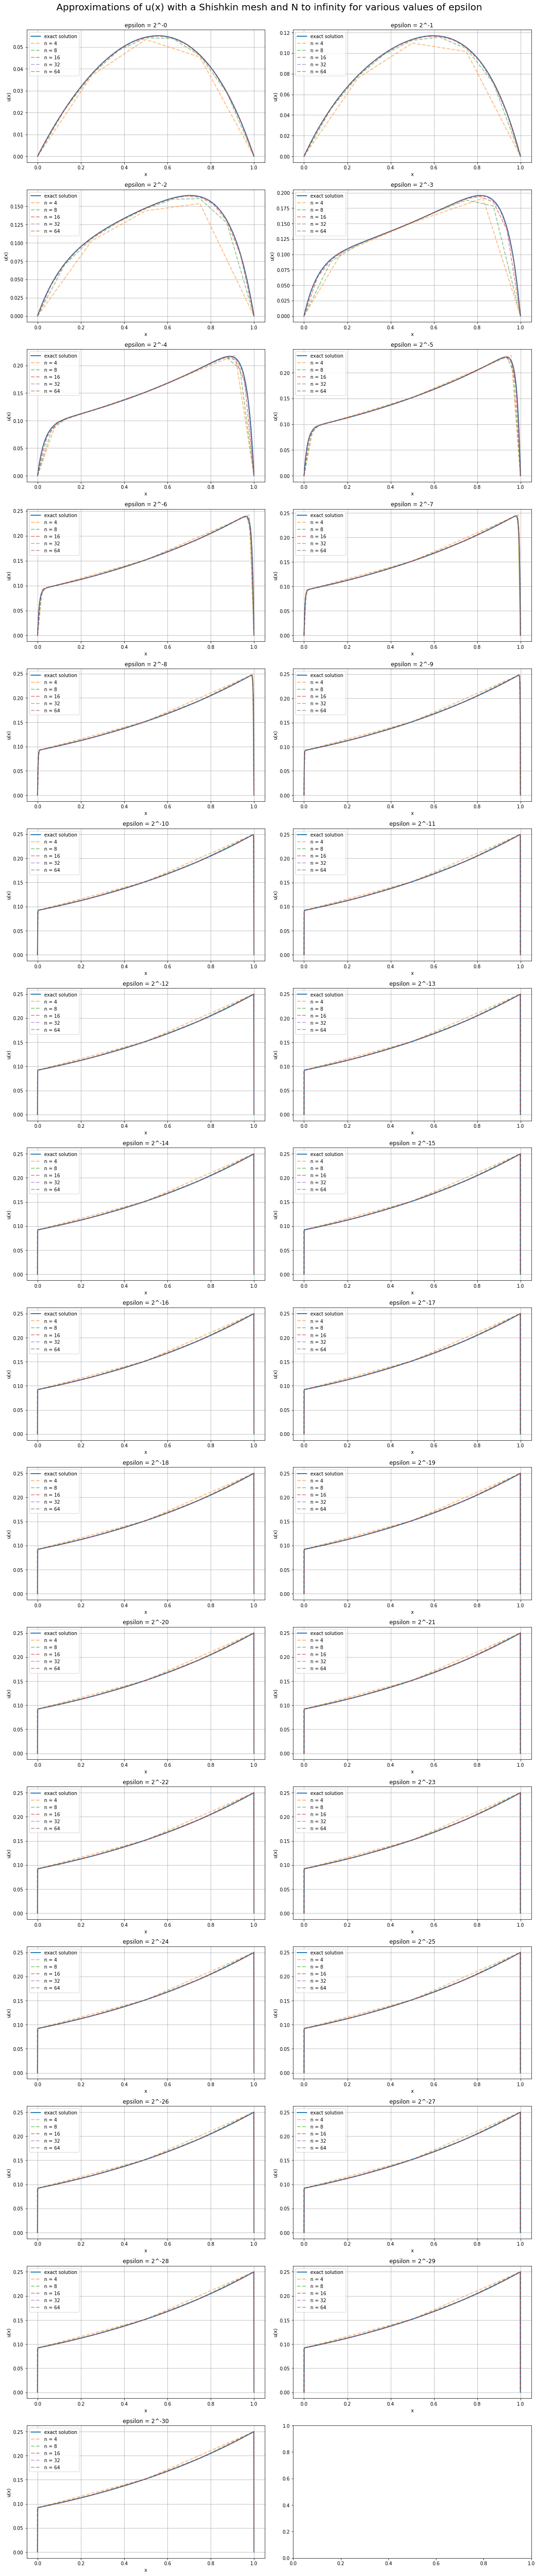

In [12]:
# Plot approximations with epsilon constant, N to infinity, for various values of epsilon

n = np.array([2**k for k in range(2, 7)]) # lower values which are still distinguishable from true solution
eps = np.array([2**(-k) for k in range(0, 31)])

# create one subplot per epsilon
height = 5 * math.ceil(len(eps)/2)
fig, axes = plt.subplots(math.ceil(len(eps)/2), 2, figsize=(16,height), tight_layout=False)
for i, (e, ax) in enumerate(zip(eps, axes.flatten())):
    # get approximations for each n
    solutions = rde.solve_multiple_n(n=n+1, eps=e, shishkin_mesh=True, sigma=2, advanced_solve=False)
    
    # exact solution
    x = np.linspace(0., 1., 1000)
    u = exact_solution(x=x, eps=e)
    sns.lineplot(x=x, y=u, linewidth=2, label=f'exact solution', ax=ax)

    # plot approximations
    for j, (x, u) in enumerate(solutions):
        sns.lineplot(x=x, y=u, linewidth=2, label=f'n = {n[j]}', alpha=0.5, linestyle='--', ax=ax)

    ax.grid()
    ax.set_title(f'epsilon = 2^-{i}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
fig.suptitle(f'Approximations of u(x) with a Shishkin mesh and N to infinity for various values of epsilon', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
if save:
    plt.savefig('../Resultate/test1_shishkin1.png', bbox_inches='tight')
plt.show()

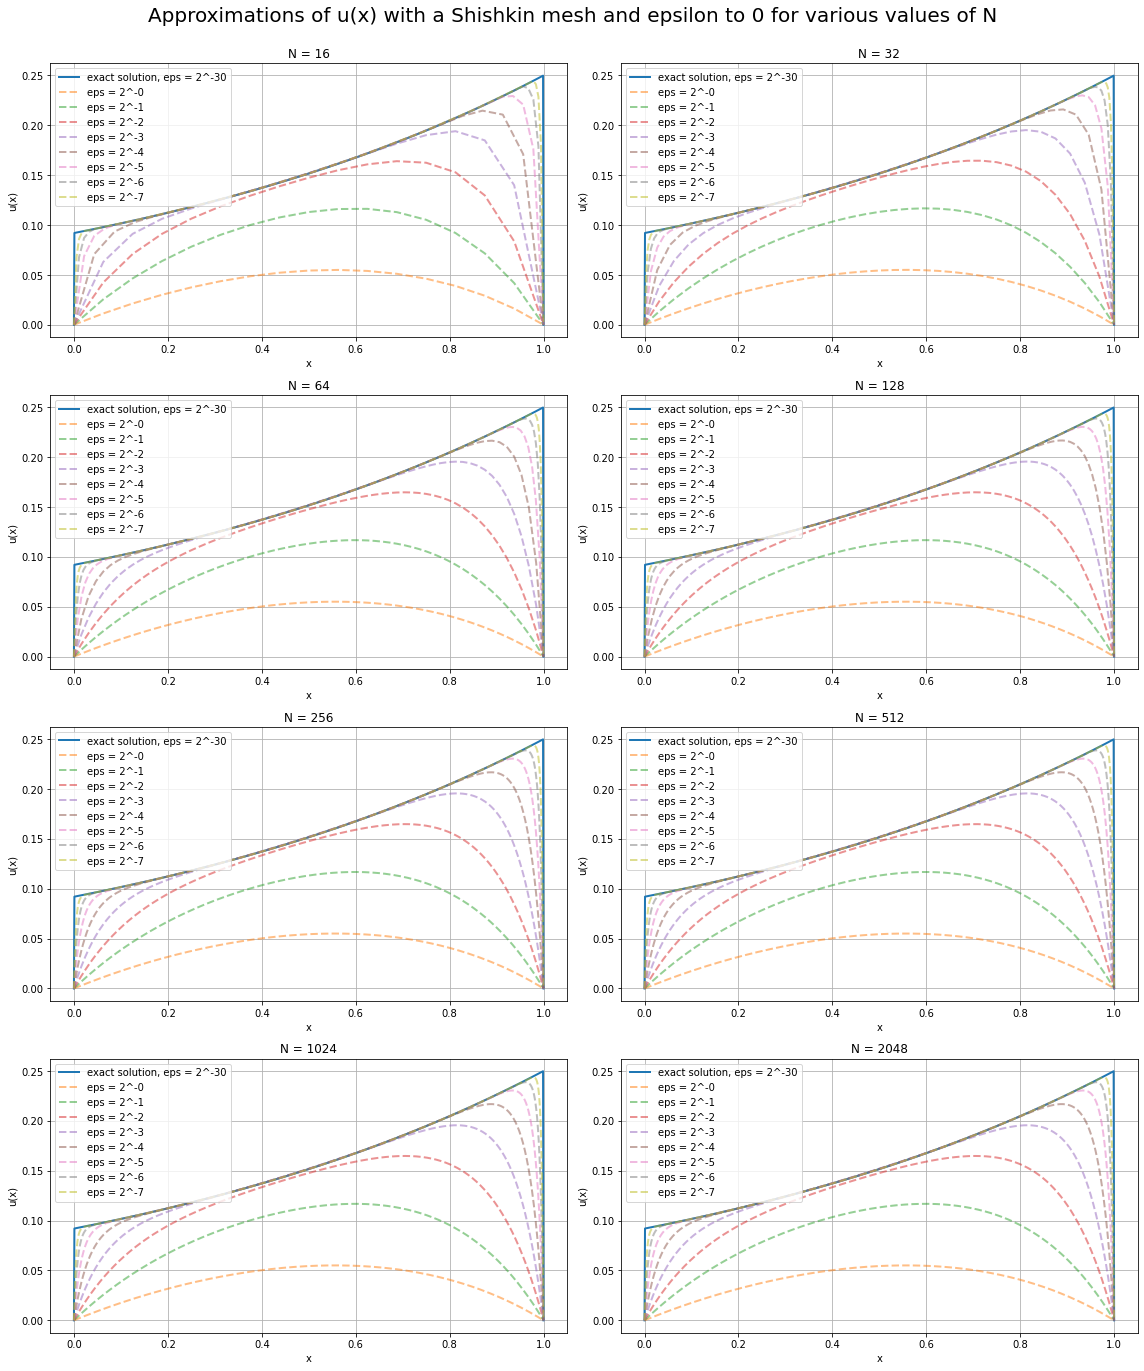

In [13]:
# Plot approximations with N constant, epsilon to 0, for various values of N

n = np.array([2**k for k in range(4, 17)])
eps = np.array([2**(-k) for k in range(0, 8)])

# create one subplot per N
height = 5 * math.ceil(len(eps)/2)
fig, axes = plt.subplots(math.ceil(len(eps)/2), 2, figsize=(16,height), tight_layout=False)
for i, (j, ax) in enumerate(zip(n, axes.flatten())):
    # get approximations for each epsilon
    solutions = rde.solve_multiple_eps(n=j+1, eps=eps, shishkin_mesh=True, sigma=2, advanced_solve=False)
    
    # exact solution
    x = np.linspace(0., 1., 1000)
    u = exact_solution(x=x, eps=2**(-30))
    sns.lineplot(x=x, y=u, linewidth=2, label=f'exact solution, eps = 2^-30', ax=ax)

    # plot approximations
    for k, (x, u) in enumerate(solutions):
        sns.lineplot(x=x, y=u, linewidth=2, label=f'eps = 2^-{k}', alpha=0.5, linestyle='--', ax=ax)

    ax.grid()
    ax.legend(loc='upper left')
    ax.set_title(f'N = {j}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
fig.suptitle(f'Approximations of u(x) with a Shishkin mesh and epsilon to 0 for various values of N', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
if save:
    plt.savefig('../Resultate/test1_shishkin2.png', bbox_inches='tight')
plt.show()

### Advanced finite difference scheme <a name="advanced1"></a>

We test our method with the advanced finite difference scheme using a Shishkin mesh with the mesh parameter $\sigma=4$ for each combination of $\varepsilon$ and $N$, $\varepsilon = 2^{-k}$ mit $k= 0, ..., 30$ und $N=2^l$ mit $l = 4, ..., 16$. We report the pointwise maximum absolute error of our approximations over all mesh points and plot selected approximations compared to the exact solution.

In [14]:
# Calculate pointwise maximum abolute errors for each combination of N and epsilon

# define values for N and epsilon
n = np.array([2**k for k in range(4, 17)])
eps = np.array([2**(-k) for k in range(0, 31)])

results = {'eps': eps} # store results

# loop over all possible values for N
for i in n:
    # get approximations for all epsilons
    appr = rde.solve_multiple_eps(eps=eps, n=i+1, shishkin_mesh=True, sigma=4, advanced_solve=True)
    
    errors = [] # to store errors per epsilon
    for j, (x, u_appr) in enumerate(appr):

        # calculate pointwise maximum absolute error
        u = exact_solution(x=x, eps=eps[j])
        error = np.abs(u_appr - u).max()
        errors.append(error)

    results[f'N = {i}'] = errors # store results

df = pd.DataFrame(results)
df = df.set_index('eps')
if save:
    df.to_csv('../Resultate/test1_advanced.csv', index=True)
df

N = 16        N = 32        N = 64       N = 128  \
eps                                                                    
1.000000e+00  5.705729e-08  3.567757e-09  2.230524e-10  1.392916e-11   
5.000000e-01  8.778444e-07  5.522684e-08  3.453275e-09  2.158411e-10   
2.500000e-01  1.211357e-05  7.624523e-07  4.774081e-08  2.985179e-09   
1.250000e-01  1.860741e-04  1.190859e-05  7.495493e-07  4.693288e-08   
6.250000e-02  2.081690e-03  1.855278e-04  1.187363e-05  7.473484e-07   
3.125000e-02  4.917967e-03  1.339426e-03  1.853918e-04  1.186493e-05   
1.562500e-02  4.917066e-03  1.339180e-03  2.159678e-04  2.507044e-05   
7.812500e-03  4.916841e-03  1.339119e-03  2.159579e-04  2.506929e-05   
3.906250e-03  4.916784e-03  1.339104e-03  2.159554e-04  2.506901e-05   
1.953125e-03  4.916770e-03  1.339100e-03  2.159548e-04  2.506893e-05   
9.765625e-04  4.916767e-03  1.339099e-03  2.159546e-04  2.506892e-05   
4.882812e-04  4.916766e-03  1.339099e-03  2.159546e-04  2.506891e-05   
2.441406e-04  4.916765e-03  1.339099e-03  2.159546e-04  2.506891e-05   
1.220703e-04  4.916765e-03  1.339099e-03  2.159546e-04  2.506891e-05   
6.103516e-05  4.916765e-03  1.339099e-03  2.159546e-04  2.506891e-05   
3.051758e-05  4.916765e-03  1.339099e-03  2.159546e-04  2.506891e-05   
1.525879e-05  4.916765e-03  1.339099e-03  2.159546e-04  2.506891e-05   
7.629395e-06  4.916765e-03  1.339099e-03  2.159546e-04  2.506892e-05   
3.814697e-06  4.916765e-03  1.339099e-03  2.159546e-04  2.506890e-05   
1.907349e-06  4.916765e-03  1.339099e-03  2.159546e-04  2.506892e-05   
9.536743e-07  4.916765e-03  1.339099e-03  2.159546e-04  2.506887e-05   
4.768372e-07  4.916765e-03  1.339099e-03  2.159545e-04  2.506887e-05   
2.384186e-07  4.916765e-03  1.339099e-03  2.159545e-04  2.506915e-05   
1.192093e-07  4.916765e-03  1.339099e-03  2.159545e-04  2.506922e-05   
5.960464e-08  4.916765e-03  1.339098e-03  2.159553e-04  2.506894e-05   
2.980232e-08  4.916765e-03  1.339098e-03  2.159550e-04  2.506700e-05   
1.490116e-08  4.916765e-03  1.339098e-03  2.159530e-04  2.506645e-05   
7.450581e-09  4.916765e-03  1.339098e-03  2.159517e-04  2.506645e-05   
3.725290e-09  4.916765e-03  1.339098e-03  2.159543e-04  2.506866e-05   
1.862645e-09  4.916765e-03  1.339098e-03  2.159543e-04  2.507752e-05   
9.313226e-10  4.916765e-03  1.339098e-03  2.159543e-04  2.514840e-05   

                   N = 256       N = 512      N = 1024      N = 2048  \
eps                                                                    
1.000000e+00  8.113440e-13  1.871212e-13  9.505036e-13  3.760943e-12   
5.000000e-01  1.343284e-11  6.336737e-13  1.028344e-12  4.372544e-12   
2.500000e-01  1.865767e-10  1.159037e-11  4.556772e-13  2.099043e-12   
1.250000e-01  2.934659e-09  1.834134e-10  1.133485e-11  5.769274e-13   
6.250000e-02  4.679507e-08  2.926038e-09  1.828548e-10  1.124636e-11   
3.125000e-02  7.468009e-07  4.676079e-08  2.923894e-09  1.827192e-10   
1.562500e-02  2.749484e-06  2.762556e-07  2.634332e-08  2.411943e-09   
7.812500e-03  2.749358e-06  2.762430e-07  2.634212e-08  2.411833e-09   
3.906250e-03  2.749327e-06  2.762399e-07  2.634179e-08  2.411846e-09   
1.953125e-03  2.749319e-06  2.762391e-07  2.634140e-08  2.412541e-09   
9.765625e-04  2.749317e-06  2.762389e-07  2.634192e-08  2.412859e-09   
4.882812e-04  2.749316e-06  2.762389e-07  2.634195e-08  2.413004e-09   
2.441406e-04  2.749316e-06  2.762389e-07  2.633938e-08  2.413086e-09   
1.220703e-04  2.749316e-06  2.762384e-07  2.633886e-08  2.413004e-09   
6.103516e-05  2.749319e-06  2.762329e-07  2.634916e-08  2.412838e-09   
3.051758e-05  2.749320e-06  2.762318e-07  2.635396e-08  2.406892e-09   
1.525879e-05  2.749318e-06  2.762524e-07  2.634984e-08  2.322976e-09   
7.629395e-06  2.749300e-06  2.762552e-07  2.626475e-08  2.303324e-09   
3.814697e-06  2.749326e-06  2.761728e-07  2.622082e-08  2.628475e-09   
1.907349e-06  2.749259e-06  2.761618e-07  2.624278e-08  2.720111e-09   
9.536743e-07  2.749228e-06  2.764254e-07  2.683574e-08  2.0

We also compute the corresponding 'Shishkin' rates of convergence obtained as $\tilde{r}^N = \frac{\ln e^N - \ln e^{2N}}{\ln \left( 2 \ln N \right) - \ln \left( \ln 2 N \right)}$ where $N$ is the number of mesh points and $e$ are the previously reported errors. 

In [15]:
# compute rates of convergence
def denom(x):
    n = int(re.findall(r'\b\d+\b', x.name)[0])
    return x / (np.log(2 * np.log(n)) - np.log(np.log(2*n)))
df_cr = df.apply(np.log).diff(-1, axis=1).apply(denom).round(2)
if save:
    df_cr.to_csv('../Resultate/test1_advanced_convergence.csv', index=True)
df_cr

N = 16  N = 32  N = 64  N = 128  N = 256  N = 512  N = 1024  \
eps                                                                         
1.000000e+00    5.90    5.43    5.15     5.08     2.55    -2.77     -2.30   
5.000000e-01    5.89    5.43    5.14     4.96     5.31    -0.82     -2.42   
2.500000e-01    5.88    5.42    5.14     4.95     4.83     5.51     -2.55   
1.250000e-01    5.85    5.41    5.14     4.95     4.82     4.74      4.98   
6.250000e-02    5.14    5.38    5.13     4.95     4.82     4.72      4.66   
3.125000e-02    2.77    3.87    5.10     4.94     4.82     4.72      4.64   
1.562500e-02    2.77    3.57    4.00     3.95     3.99     4.00      4.00   
7.812500e-03    2.77    3.57    4.00     3.95     3.99     4.00      4.00   
3.906250e-03    2.77    3.57    4.00     3.95     3.99     4.00      4.00   
1.953125e-03    2.77    3.57    4.00     3.95     3.99     4.00      4.00   
9.765625e-04    2.77    3.57    4.00     3.95     3.99     4.00      4.00   
4.882812e-04    2.77    3.57    4.00     3.95     3.99     4.00      4.00   
2.441406e-04    2.77    3.57    4.00     3.95     3.99     4.00      4.00   
1.220703e-04    2.77    3.57    4.00     3.95     3.99     4.00      4.00   
6.103516e-05    2.77    3.57    4.00     3.95     3.99     4.00      4.00   
3.051758e-05    2.77    3.57    4.00     3.95     3.99     4.00      4.00   
1.525879e-05    2.77    3.57    4.00     3.95     3.99     4.00      4.06   
7.629395e-06    2.77    3.57    4.00     3.95     3.99     4.00      4.07   
3.814697e-06    2.77    3.57    4.00     3.95     3.99     4.01      3.85   
1.907349e-06    2.77    3.57    4.00     3.95     3.99     4.00      3.79   
9.536743e-07    2.77    3.57    4.00     3.95     3.99     3.97      4.32   
4.768372e-07    2.77    3.57    4.00     3.95     4.00     4.02      3.26   
2.384186e-07    2.77    3.57    4.00     3.95     4.00     3.90      2.08   
1.192093e-07    2.77    3.57    4.00     3.95     3.98     4.19      0.91   
5.960464e-08    2.77    3.57    4.00     3.95     4.01     4.31      0.48   
2.980232e-08    2.77    3.57    4.00     3.95     4.02     4.34      0.43   
1.490116e-08    2.77    3.57    4.00     3.95     4.02     4.34     -3.83   
7.450581e-09    2.77    3.57    4.00     3.95     3.98     3.59     -3.75   
3.725290e-09    2.77    3.57    4.00     3.95     3.51    -0.24      0.22   
1.862645e-09    2.77    3.57    3.99     3.95     4.19     0.27     -1.05   
9.313226e-10    2.77    3.57    3.99     3.96     2.52     0.33      0.62   

              N = 2048  N = 4096  N = 8192  N = 16384  N = 32768  N = 65536  
eps                                                                          
1.000000e+00     -2.32     -2.25     -2.24      -2.22      -2.21        NaN  
5.000000e-01     -2.27     -2.27     -2.23      -2.23      -2.20        NaN  
2.500000e-01     -2.30     -2.24     -2.26      -2.22      -2.30        NaN  
1.250000e-01     -2.94     -2.21     -2.81      -2.09      -2.40        NaN  
6.250000e-02      3.69     -2.42     -2.02      -2.63      -2.02        NaN  
3.125000e-02      4.60      3.49     -2.37      -2.00      -2.61        NaN  
1.562500e-02      4.26      4.55      3.36      -2.33      -1.99        NaN  
7.812500e-03      4.00      4.00      2.27      -0.57      -1.92        NaN  
3.906250e-03      4.00      3.86      2.03      -0.67      -1.73        NaN  
1.953125e-03      3.99      3.83      1.93      -2.03      -0.34        NaN  
9.765625e-04      4.01      4.23      1.48      -2.19      -2.10        NaN  
4.882812e-04      3.98      3.61     -1.28      -0.50      -0.33        NaN  
2.441406e-04      4.05      3.05     -0.18      -1.89      -1.48        NaN  
1.220703e-04      4.08      2.14     -1.65      -0.84      -1.00        NaN  
6.103516e-05      4.06      0.39     -0.46      -1.30      -0.27        NaN  
3.051758e-05      3.47      0.75     -1.23      -1.22       0.51        NaN  
1.525879e-05      4.43     -2.04     -1.45       0.43       0.76    

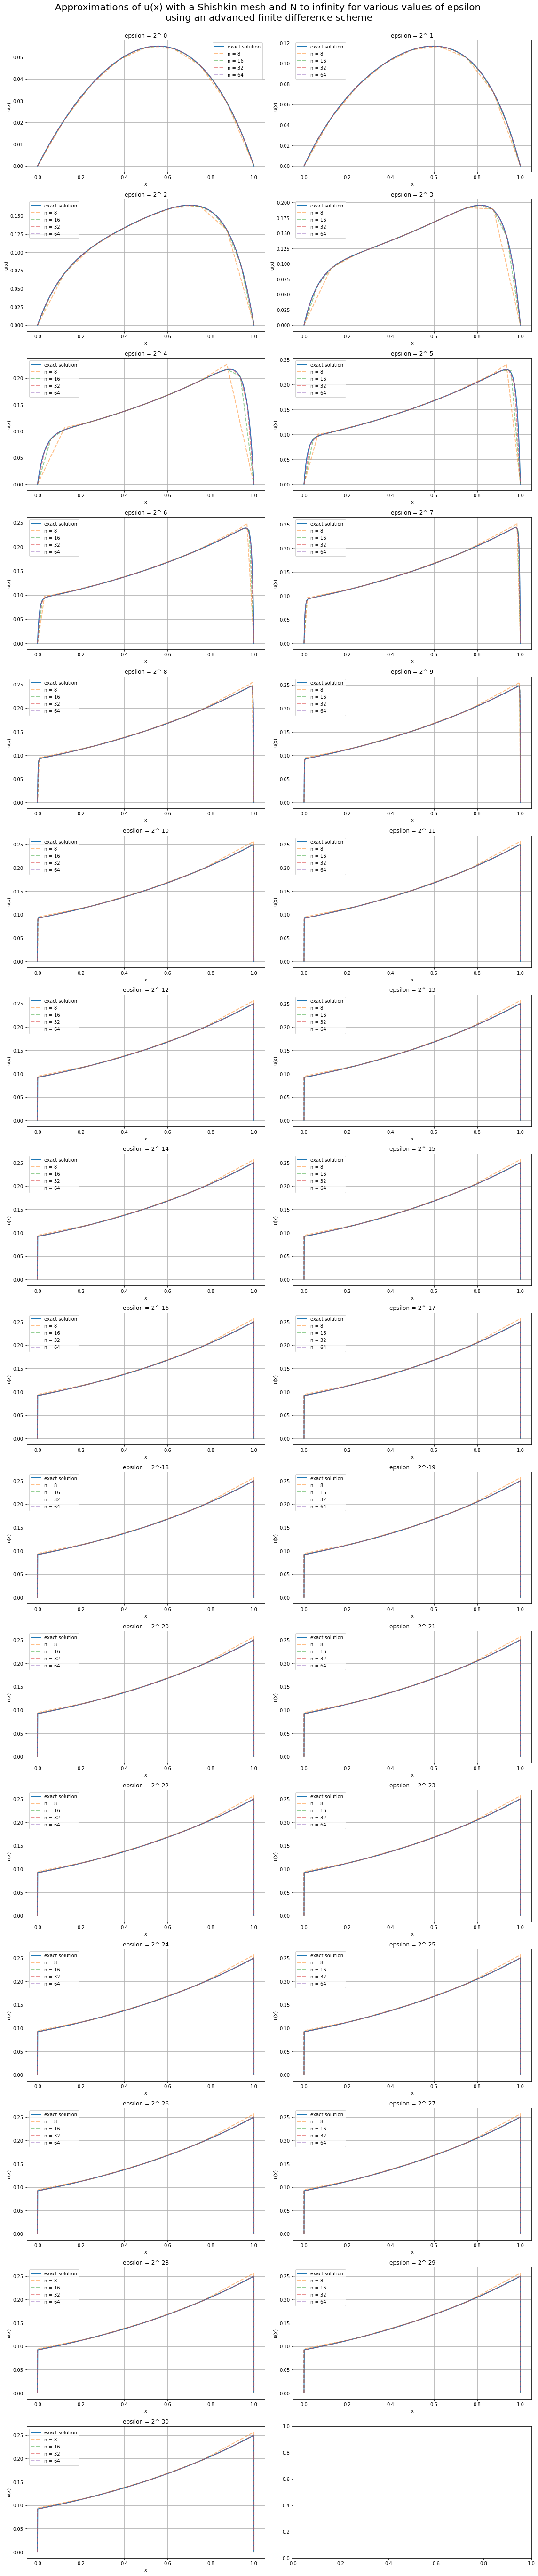

In [16]:
# Plot approximations with epsilon constant, N to infinity, for various values of epsilon

n = np.array([2**k for k in range(3, 7)]) # lower values which are still distinguishable from true solution
eps = np.array([2**(-k) for k in range(0, 31)])

# create one subplot per epsilon
height = 5 * math.ceil(len(eps)/2)
fig, axes = plt.subplots(math.ceil(len(eps)/2), 2, figsize=(16,height), tight_layout=False)
for i, (e, ax) in enumerate(zip(eps, axes.flatten())):
    # get approximations for each n
    solutions = rde.solve_multiple_n(n=n+1, eps=e, shishkin_mesh=True, sigma=4, advanced_solve=True)
    
    # exact solution
    x = np.linspace(0., 1., 1000)
    u = exact_solution(x=x, eps=e)
    sns.lineplot(x=x, y=u, linewidth=2, label=f'exact solution', ax=ax)

    # plot approximations
    for j, (x, u) in enumerate(solutions):
        sns.lineplot(x=x, y=u, linewidth=2, label=f'n = {n[j]}', alpha=0.5, linestyle='--', ax=ax)

    ax.grid()
    ax.set_title(f'epsilon = 2^-{i}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
fig.suptitle(f'Approximations of u(x) with a Shishkin mesh and N to infinity for various values of epsilon \nusing an advanced finite difference scheme', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
if save:
    plt.savefig('../Resultate/test1_advanced1.png', bbox_inches='tight')
plt.show()

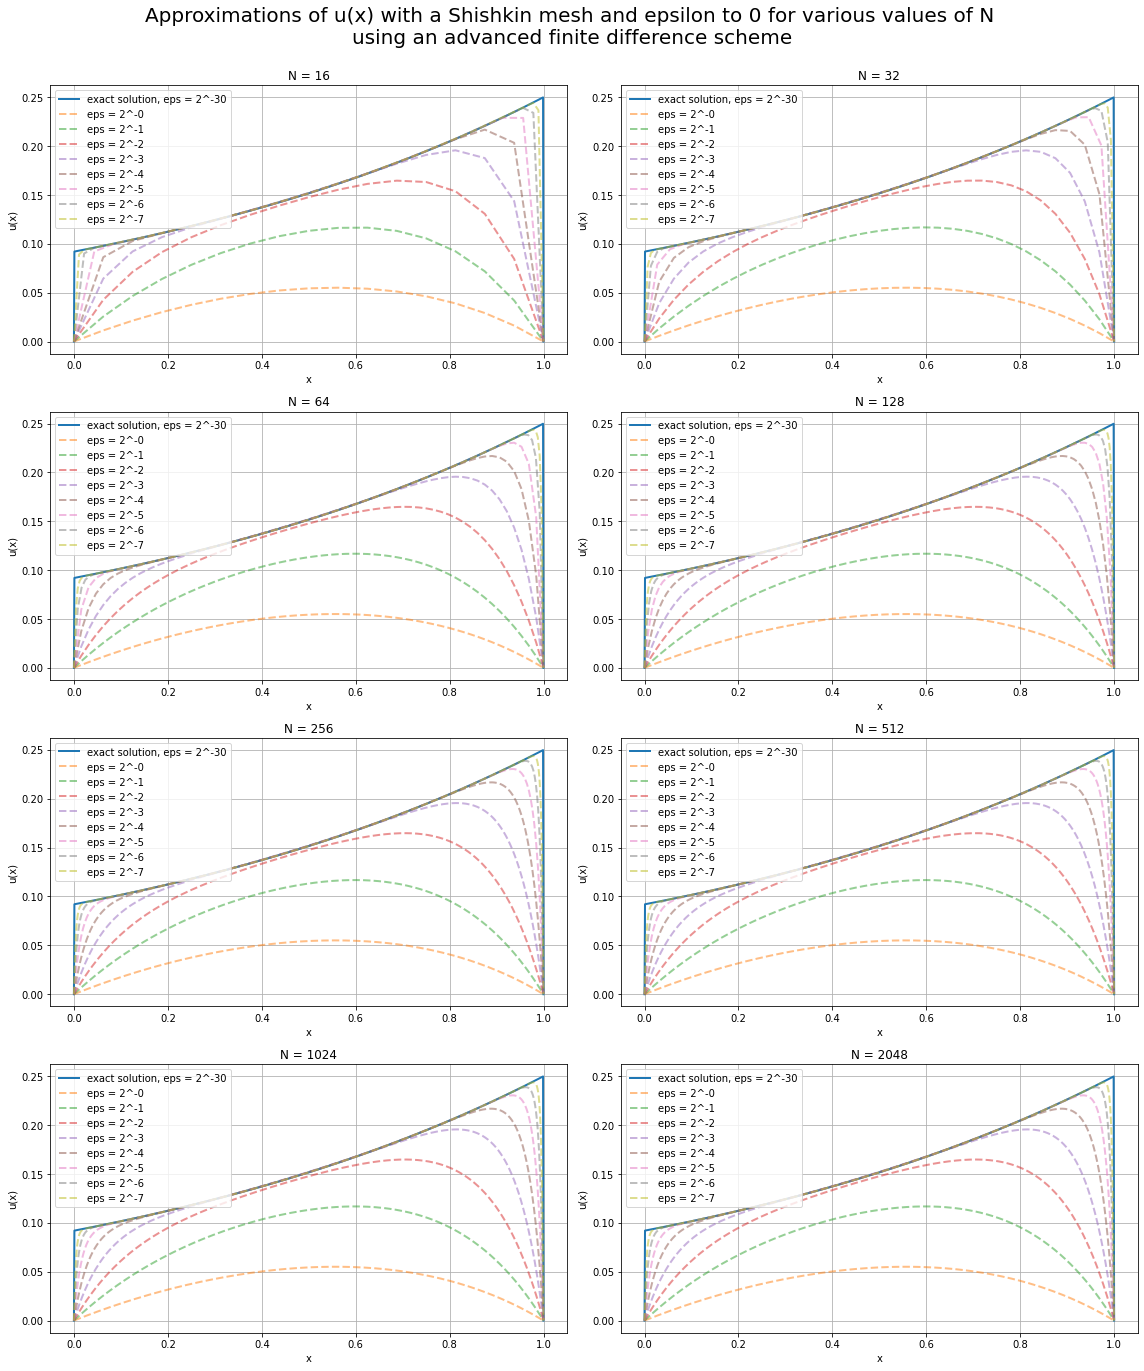

In [17]:
# Plot approximations with N constant, epsilon to 0, for various values of N

n = np.array([2**k for k in range(4, 17)])
eps = np.array([2**(-k) for k in range(0, 8)])

# create one subplot per N
height = 5 * math.ceil(len(eps)/2)
fig, axes = plt.subplots(math.ceil(len(eps)/2), 2, figsize=(16,height), tight_layout=False)
for i, (j, ax) in enumerate(zip(n, axes.flatten())):
    # get approximations for each epsilon
    solutions = rde.solve_multiple_eps(n=j+1, eps=eps, shishkin_mesh=True, sigma=4, advanced_solve=True)
    
    # exact solution
    x = np.linspace(0., 1., 1000)
    u = exact_solution(x=x, eps=2**(-30))
    sns.lineplot(x=x, y=u, linewidth=2, label=f'exact solution, eps = 2^-30', ax=ax)

    # plot approximations
    for k, (x, u) in enumerate(solutions):
        sns.lineplot(x=x, y=u, linewidth=2, label=f'eps = 2^-{k}', alpha=0.5, linestyle='--', ax=ax)

    ax.grid()
    ax.legend(loc='upper left')
    ax.set_title(f'N = {j}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
fig.suptitle(f'Approximations of u(x) with a Shishkin mesh and epsilon to 0 for various values of N \nusing an advanced finite difference scheme', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
if save:
    plt.savefig('../Resultate/test1_advanced2.png', bbox_inches='tight')
plt.show()

### Comparison <a name="comparison1"></a>

Previously reported errors may suggest that a Shishkin mesh and advanced finite difference methods may lead to no improvement over the base solution. However, this is because the Shishkin mesh shifts mesh points into the boundary layers, where function values change more abruptly which generally yields larger errors. Maximum absolute errors are commonly obtained in these boundary layers, whereas most mesh points of a uniform mesh are not inside boundary layers (for low values of $N$). Here, we visually compare the resulting approximations to show the improvements for selected combinations of $N$ and $\varepsilon$.

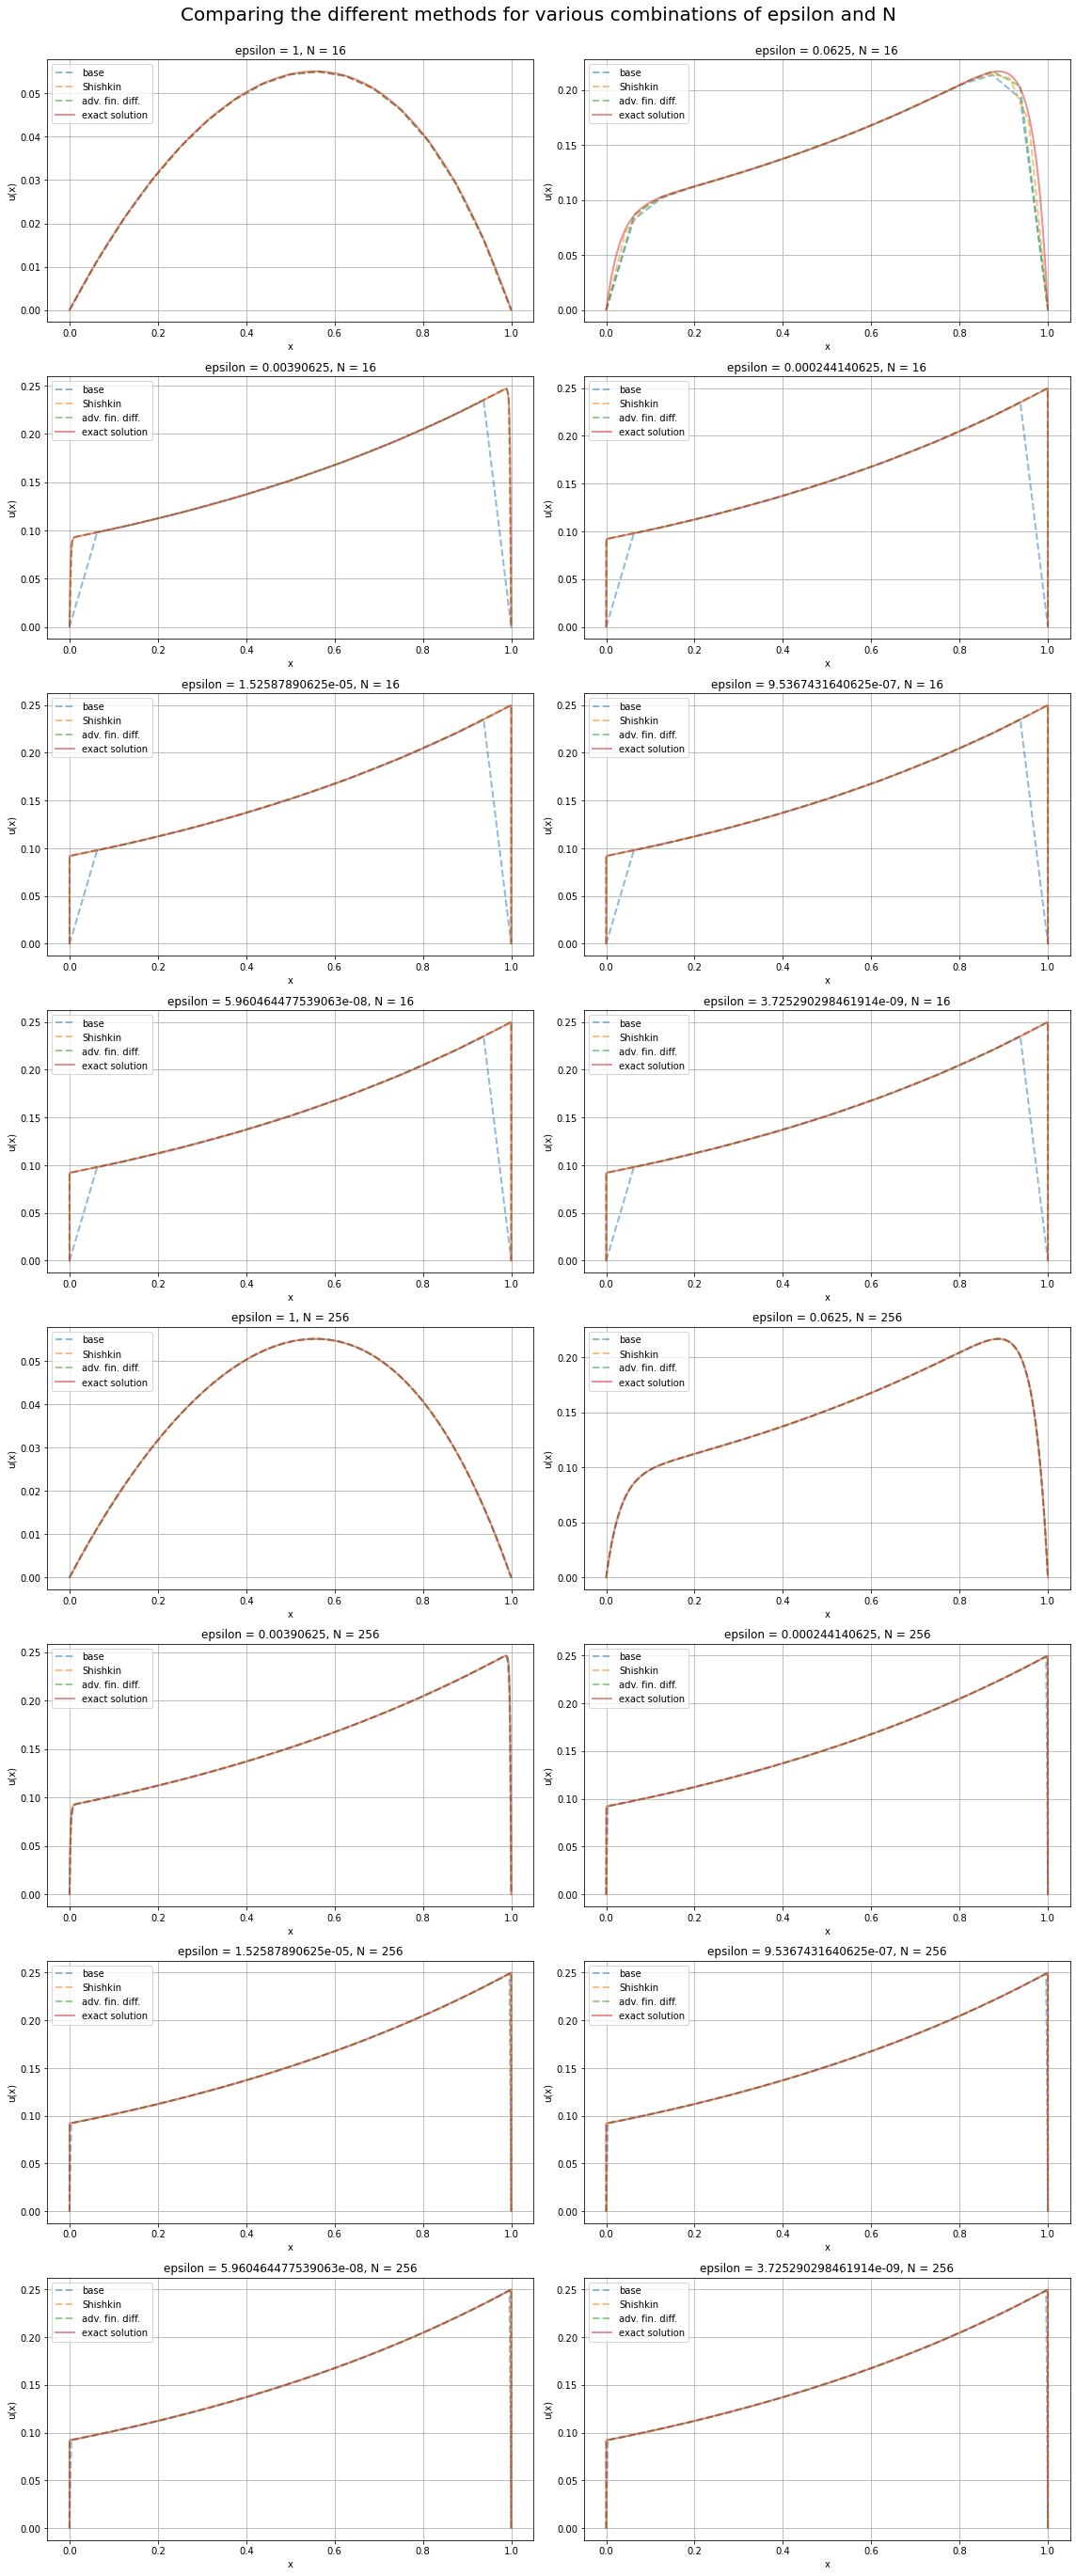

In [18]:
# define combinations of N and epsilon to depict
params = [(4, 0), (4, 4), (4, 8), (4, 12), (4, 16), (4, 20), (4, 24), (4, 28), (8, 0), (8, 4), (8, 8), (8, 12), (8, 16), (8, 20), (8, 24), (8, 28)]
params = [(2**l + 1, 2**(-k)) for l, k in params]

# create one subplot per epsilon
height = 5 * math.ceil(len(params)/2)
fig, axes = plt.subplots(math.ceil(len(params)/2), 2, figsize=(16,height), tight_layout=False)
for i, ((n, eps), ax) in enumerate(zip(params, axes.flatten())):
    # create approximations with the different methods
    x_base, u_base = rde.solve(eps=eps, n=n, shishkin_mesh=False, sigma=2, 
                                advanced_solve=False, verbose=False)
    x_opt, u_opt = rde.solve(eps=eps, n=n, shishkin_mesh=True, sigma=2, 
                        advanced_solve=False, verbose=False)
    x_full, u_full = rde.solve(eps=eps, n=n, shishkin_mesh=True, sigma=4, 
                        advanced_solve=True, verbose=False)

    # exact solution for reference
    x = np.sort(np.concatenate([x_base, x_opt, x_full, np.linspace(0, 1, 1000)]))
    u = exact_solution(x, eps)

    # plotting
    solutions = [(x_base, u_base), (x_opt, u_opt), (x_full, u_full), (x, u)]
    titles = {0: 'base', 1: 'Shishkin', 2: 'adv. fin. diff.', 3: 'exact solution'}
    for i, (x, u) in enumerate(solutions):
        linestyle = '--' if i < 3 else '-'
        sns.lineplot(x=x, y=u, linewidth=2, label=titles[i], alpha=0.5, ax=ax, linestyle=linestyle)

    ax.grid()
    ax.legend(loc='upper left')
    ax.set_title(f'epsilon = {eps}, N = {n-1}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')

fig.suptitle(f'Comparing the different methods for various combinations of epsilon and N', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
if save:
    plt.savefig('../Resultate/test1_comparison.png', bbox_inches='tight')
plt.show()

## Test case II: $- \epsilon^2 u''(x) + (1+x) u(x) = x^\alpha, \quad \alpha \ge 1$ <a name="test2"></a>

First, we analyze the implemented methods for $- \epsilon^2 u''(x) + (1+x) u(x) = x^\alpha, \quad \alpha \ge 1$, $u(0)=u(1)=0$, for which no closed form solution exists. To estimate errors nonetheless, we use the double mesh principle.

In [19]:
# create class instance
a = 3
f = lambda x: x**a
c = lambda x: 1 + x
rde = ReactionDiffusionEquation(f=f, c=c)

### Uniform mesh <a name="uniform2"></a>

We test our method using a uniform mesh for each combination of $\varepsilon$ and $N$, $\varepsilon = 2^{-k}$ mit $k= 0, ..., 30$ und $N=2^l$ mit $l = 4, ..., 16$. We report the pointwise maximum absolute error of our approximations over all mesh points using the double mesh principle and plot selected approximations.

In [20]:
# Calculate pointwise maximum abolute errors for each combination of N and epsilon

# define values for N and epsilon
n = np.array([2**k for k in range(4, 17)])
eps = np.array([2**(-k) for k in range(0, 31)])

results = {'eps': eps} # store results

# loop over all possible values for N
for i in n:

    errors = [] # to store errors per epsilon
    # get approximations for all epsilons
    for e in eps:
        (x, u_appr), (x_ref, u_ref) = rde.solve(eps=e, n=i+1, shishkin_mesh=False, sigma=2, advanced_solve=False, double_mesh=True)
        u_ref = u_ref[np.where(np.in1d(x_ref, x))[0]] # only compare at mesh points of original approximations
        
        # calculate pointwise maximum absolute error
        error = np.abs(u_appr - u_ref).max()
        errors.append(error)

    results[f'N = {i}'] = errors # store results

df = pd.DataFrame(results)
df = df.set_index('eps')
if save:
    df.to_csv('../Resultate/test2_uniform.csv', index=True)
df

N = 16        N = 32        N = 64       N = 128  \
eps                                                                    
1.000000e+00  8.868207e-05  2.224146e-05  5.561642e-06  1.390866e-06   
5.000000e-01  3.005563e-04  7.539644e-05  1.888622e-05  4.722509e-06   
2.500000e-01  8.873857e-04  2.244184e-04  5.626840e-05  1.408676e-05   
1.250000e-01  2.781758e-03  7.682064e-04  1.941898e-04  4.873439e-05   
6.250000e-02  9.262373e-03  2.654787e-03  7.318925e-04  1.849555e-04   
3.125000e-02  1.492728e-02  9.100499e-03  2.606908e-03  7.182269e-04   
1.562500e-02  9.864742e-03  1.476072e-02  9.033168e-03  2.586590e-03   
7.812500e-03  3.515778e-03  9.737528e-03  1.468413e-02  9.002799e-03   
3.906250e-03  9.730420e-04  3.463562e-03  9.676091e-03  1.464746e-02   
1.953125e-03  2.497803e-04  9.578680e-04  3.438119e-03  9.645899e-03   
9.765625e-04  6.286361e-05  2.458330e-04  9.504637e-04  3.425560e-03   
4.882812e-04  1.574224e-05  6.186681e-05  2.439064e-04  9.468058e-04   
2.441406e-04  3.937209e-06  1.549241e-05  6.138024e-05  2.429544e-04   
1.220703e-04  9.844053e-07  3.874712e-06  1.537046e-05  6.113982e-05   
6.103516e-05  2.461078e-07  9.687786e-07  3.844204e-06  1.531020e-05   
3.051758e-05  6.152734e-08  2.422009e-07  9.611504e-07  3.829130e-06   
1.525879e-05  1.538186e-08  6.055063e-08  2.402938e-07  9.573813e-07   
7.629395e-06  3.845467e-09  1.513768e-08  6.007384e-08  2.393515e-07   
3.814697e-06  9.613668e-10  3.784422e-09  1.501849e-08  5.983826e-08   
1.907349e-06  2.403417e-10  9.461056e-10  3.754623e-09  1.495959e-08   
9.536743e-07  6.008544e-11  2.365264e-10  9.386558e-10  3.739899e-09   
4.768372e-07  1.502137e-11  5.913164e-11  2.346640e-10  9.349748e-10   
2.384186e-07  3.755385e-12  1.478284e-11  5.866602e-11  2.337437e-10   
1.192093e-07  9.388601e-13  3.695766e-12  1.466649e-11  5.843592e-11   
5.960464e-08  2.347011e-13  9.239831e-13  3.666678e-12  1.460898e-11   
2.980232e-08  5.867529e-14  2.309819e-13  9.166556e-13  3.652245e-12   
1.490116e-08  1.471046e-14  5.778711e-14  2.292055e-13  9.131029e-13   
7.450581e-09  3.608225e-15  1.437739e-14  5.723200e-14  2.282063e-13   
3.725290e-09  9.436896e-16  3.663736e-15  1.432188e-14  5.706546e-14   
1.862645e-09  2.220446e-16  8.881784e-16  3.608225e-15  1.426637e-14   
9.313226e-10  5.551115e-17  2.220446e-16  8.881784e-16  3.608225e-15   

                   N = 256       N = 512      N = 1024      N = 2048  \
eps                                                                    
1.000000e+00  3.477215e-07  8.693071e-08  2.173269e-08  5.433208e-09   
5.000000e-01  1.180687e-06  2.951754e-07  7.379404e-08  1.844863e-08   
2.500000e-01  3.522342e-06  8.806263e-07  2.201615e-07  5.504065e-08   
1.250000e-01  1.219712e-05  3.049961e-06  7.625517e-07  1.906400e-07   
6.250000e-02  4.642436e-05  1.161751e-05  2.905174e-06  7.263313e-07   
3.125000e-02  1.814736e-04  4.555102e-05  1.139860e-05  2.850457e-06   
1.562500e-02  7.124250e-04  1.799932e-04  4.517919e-05  1.130544e-05   
7.812500e-03  2.577312e-03  7.097743e-04  1.793162e-04  4.500902e-05   
3.906250e-03  8.988428e-03  2.572891e-03  7.085106e-04  1.789933e-04   
1.953125e-03  1.462953e-02  8.981445e-03  2.570734e-03  7.078941e-04   
9.765625e-04  9.630934e-03  1.462067e-02  8.978004e-03  2.569669e-03   
4.882812e-04  3.419319e-03  9.623483e-03  1.461626e-02  8.976296e-03   
2.441406e-04  9.449878e-04  3.416209e-03  9.619766e-03  1.461407e-02   
1.220703e-04  2.424813e-04  9.440815e-04  3.414657e-03  9.617909e-03   
6.103516e-05  6.102032e-05  2.422454e-04  9.436291e-04  3.413881e-03   
3.051758e-05  1.528025e-05  6.096074e-05  2.421276e-04  9.434030e-04   
1.525879e-05  3.821637e-06  1.526531e-05  6.093100e-05  2.420688e-04   
7.629395e-06  9.555078e-07  3.817902e-06  1.525786e-05  6.091614e-05   
3.814697e-06  2.388831e-07  9.545738e-07  3.816037e-06  1.525413e-05   
1.907349e-06  5.972116e-08  2.386496e-07  9.541074e-07  3.815105e-06   
9.536743e-07  1.493031e-08  5.966278e-08  2.385330e-07  9.5

We also compute the corresponding rates of convergence obtained as $r^N = \log_2(\frac{e^N}{e^{2N}})$ where $N$ is the number of mesh points and $e$ are the previously reported errors.

In [21]:
# compute rates of convergence
df_cr = df.apply(np.log2).diff(-1, axis=1).round(2)
if save:
    df_cr.to_csv('../Resultate/test2_uniform_convergence.csv', index=True)
df_cr

N = 16  N = 32  N = 64  N = 128  N = 256  N = 512  N = 1024  \
eps                                                                         
1.000000e+00    2.00    2.00    2.00     2.00     2.00     2.00      2.00   
5.000000e-01    2.00    2.00    2.00     2.00     2.00     2.00      2.00   
2.500000e-01    1.98    2.00    2.00     2.00     2.00     2.00      2.00   
1.250000e-01    1.86    1.98    1.99     2.00     2.00     2.00      2.00   
6.250000e-02    1.80    1.86    1.98     1.99     2.00     2.00      2.00   
3.125000e-02    0.71    1.80    1.86     1.98     1.99     2.00      2.00   
1.562500e-02   -0.58    0.71    1.80     1.86     1.98     1.99      2.00   
7.812500e-03   -1.47   -0.59    0.71     1.80     1.86     1.98      1.99   
3.906250e-03   -1.83   -1.48   -0.60     0.70     1.80     1.86      1.98   
1.953125e-03   -1.94   -1.84   -1.49    -0.60     0.70     1.80      1.86   
9.765625e-04   -1.97   -1.95   -1.85    -1.49    -0.60     0.70      1.80   
4.882812e-04   -1.97   -1.98   -1.96    -1.85    -1.49    -0.60      0.70   
2.441406e-04   -1.98   -1.99   -1.98    -1.96    -1.85    -1.49     -0.60   
1.220703e-04   -1.98   -1.99   -1.99    -1.99    -1.96    -1.85     -1.49   
6.103516e-05   -1.98   -1.99   -1.99    -1.99    -1.99    -1.96     -1.86   
3.051758e-05   -1.98   -1.99   -1.99    -2.00    -2.00    -1.99     -1.96   
1.525879e-05   -1.98   -1.99   -1.99    -2.00    -2.00    -2.00     -1.99   
7.629395e-06   -1.98   -1.99   -1.99    -2.00    -2.00    -2.00     -2.00   
3.814697e-06   -1.98   -1.99   -1.99    -2.00    -2.00    -2.00     -2.00   
1.907349e-06   -1.98   -1.99   -1.99    -2.00    -2.00    -2.00     -2.00   
9.536743e-07   -1.98   -1.99   -1.99    -2.00    -2.00    -2.00     -2.00   
4.768372e-07   -1.98   -1.99   -1.99    -2.00    -2.00    -2.00     -2.00   
2.384186e-07   -1.98   -1.99   -1.99    -2.00    -2.00    -2.00     -2.00   
1.192093e-07   -1.98   -1.99   -1.99    -2.00    -2.00    -2.00     -2.00   
5.960464e-08   -1.98   -1.99   -1.99    -2.00    -2.00    -2.00     -2.00   
2.980232e-08   -1.98   -1.99   -1.99    -2.00    -2.00    -2.00     -2.00   
1.490116e-08   -1.97   -1.99   -1.99    -2.00    -2.00    -2.00     -2.00   
7.450581e-09   -1.99   -1.99   -2.00    -2.00    -2.00    -2.00     -2.00   
3.725290e-09   -1.96   -1.97   -1.99    -2.00    -2.00    -2.00     -2.00   
1.862645e-09   -2.00   -2.02   -1.98    -2.00    -2.00    -2.00     -2.00   
9.313226e-10   -2.00   -2.00   -2.02    -1.98    -2.00    -2.00     -2.00   

              N = 2048  N = 4096  N = 8192  N = 16384  N = 32768  N = 65536  
eps                                                                          
1.000000e+00      2.00      2.00      2.05       2.48       1.11        NaN  
5.000000e-01      2.00      2.00      2.06       1.57       2.23        NaN  
2.500000e-01      2.00      2.00      2.00       2.04      -0.36        NaN  
1.250000e-01      2.00      2.00      2.00       1.95       1.05        NaN  
6.250000e-02      2.00      2.00      2.00       2.01       1.97        NaN  
3.125000e-02      2.00      2.00      2.00       2.00       2.00        NaN  
1.562500e-02      2.00      2.00      2.00       2.00       2.00        NaN  
7.812500e-03      2.00      2.00      2.00       2.00       2.00        NaN  
3.906250e-03      1.99      2.00      2.00       2.00       2.00        NaN  
1.953125e-03      1.98      1.99      2.00       2.00       2.00        NaN  
9.765625e-04      1.86      1.98      1.99       2.00       2.00        NaN  
4.882812e-04      1.80      1.86      1.98       1.99       2.00        NaN  
2.441406e-04      0.70      1.80      1.86       1.98       1.99        NaN  
1.220703e-04     -0.60      0.70      1.80       1.86       1.98        NaN  
6.103516e-05     -1.49     -0.60      0.70       1.80       1.86        NaN  
3.051758e-05     -1.86     -1.49     -0.60       0.70       1.80        NaN  
1.525879e-05     -1.96     -1.86     -1.49      -0.60       0.70    

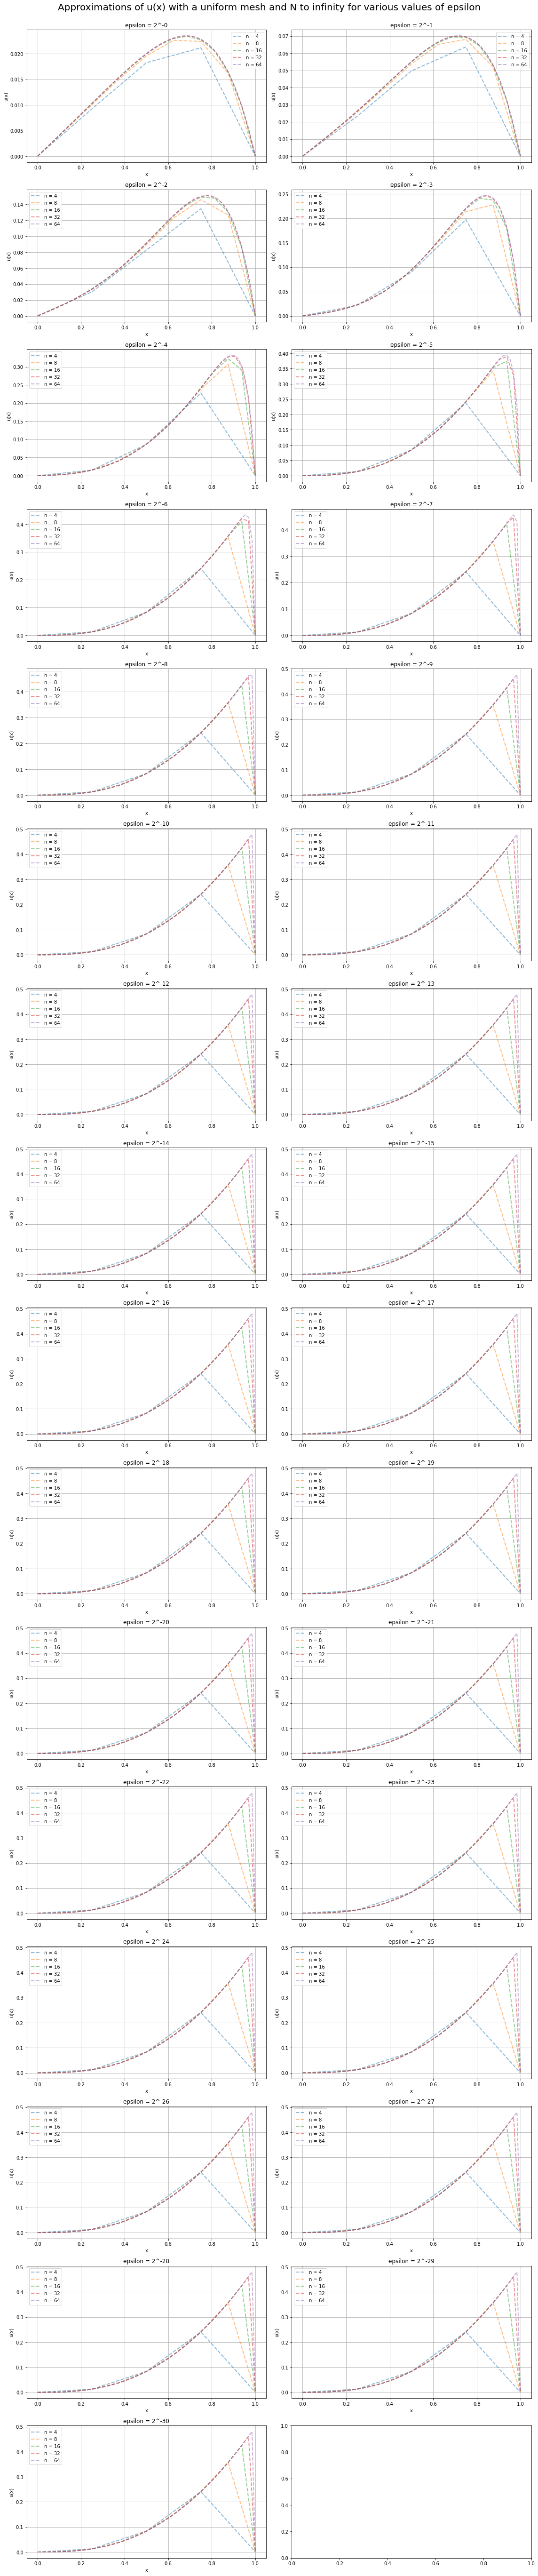

In [22]:
# Plot approximations with epsilon constant, N to infinity, for various values of epsilon

n = np.array([2**k for k in range(2, 7)]) # lower values which are still distinguishable from true solution
eps = np.array([2**(-k) for k in range(0, 31)])

# create one subplot per epsilon
height = 5 * math.ceil(len(eps)/2)
fig, axes = plt.subplots(math.ceil(len(eps)/2), 2, figsize=(16,height), tight_layout=False)
for i, (e, ax) in enumerate(zip(eps, axes.flatten())):
    # get approximations for each n
    solutions = rde.solve_multiple_n(n=n+1, eps=e, shishkin_mesh=False, sigma=2, advanced_solve=False)

    # plot approximations
    for j, (x, u) in enumerate(solutions):
        sns.lineplot(x=x, y=u, linewidth=2, label=f'n = {n[j]}', alpha=0.5, linestyle='--', ax=ax)

    ax.grid()
    ax.set_title(f'epsilon = 2^-{i}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
fig.suptitle(f'Approximations of u(x) with a uniform mesh and N to infinity for various values of epsilon', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
if save:
    plt.savefig('../Resultate/test2_uniform1.png', bbox_inches='tight')
plt.show()

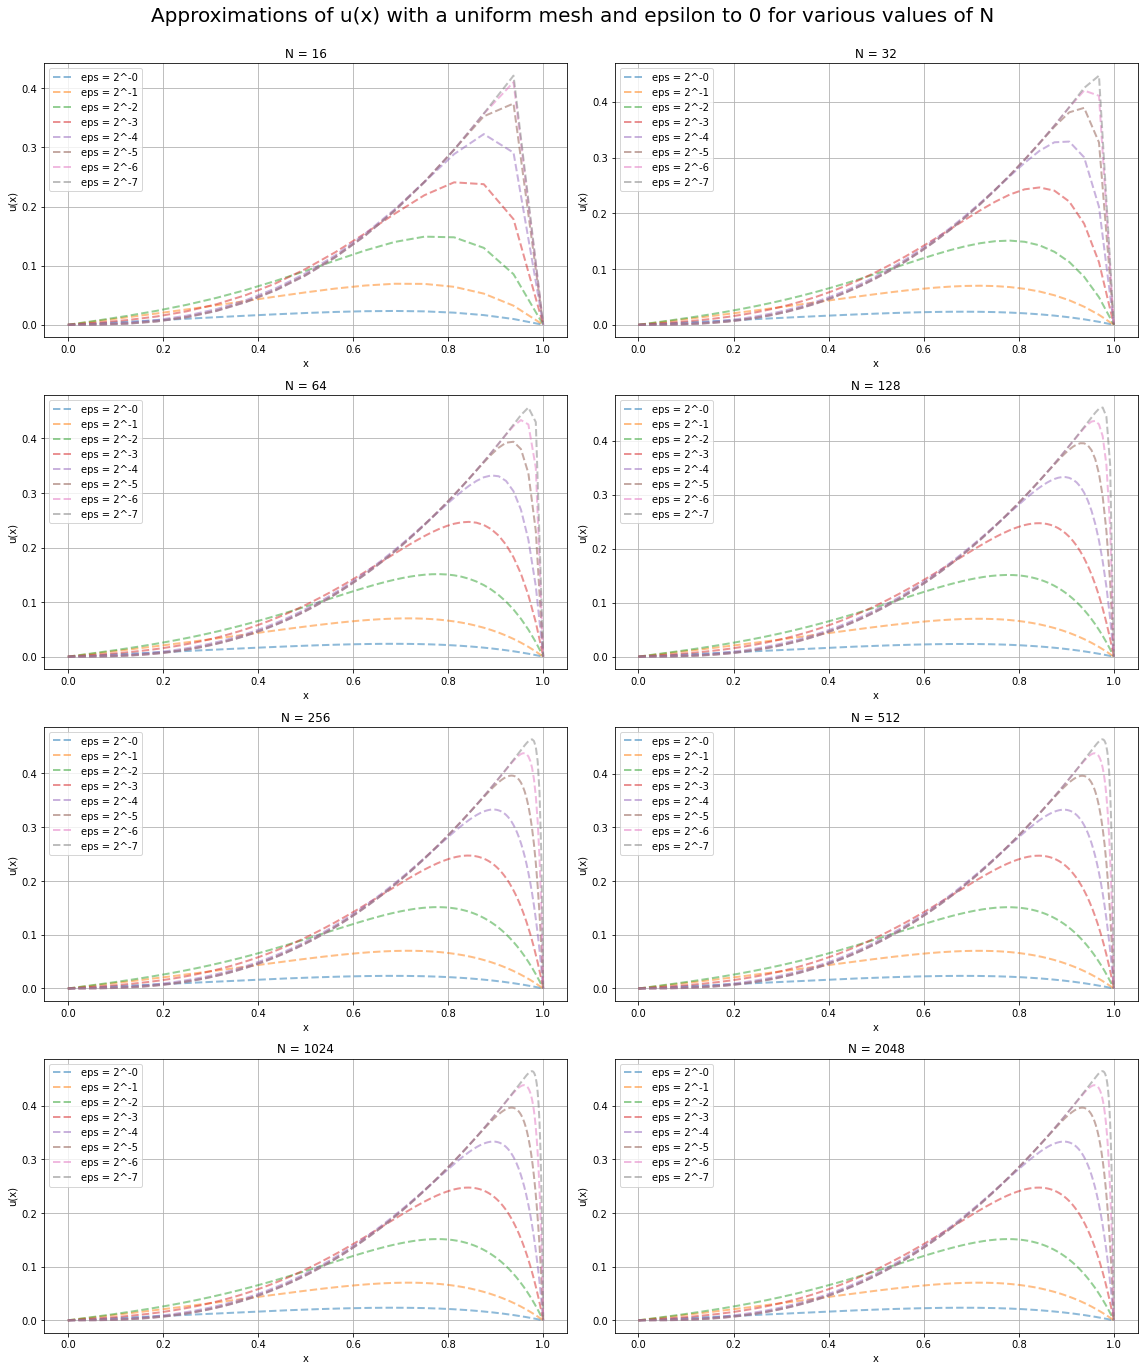

In [23]:
# Plot approximations with N constant, epsilon to 0, for various values of N

n = np.array([2**k for k in range(4, 17)])
eps = np.array([2**(-k) for k in range(0, 8)])

# create one subplot per N
height = 5 * math.ceil(len(eps)/2)
fig, axes = plt.subplots(math.ceil(len(eps)/2), 2, figsize=(16,height), tight_layout=False)
for i, (j, ax) in enumerate(zip(n, axes.flatten())):
    # get approximations for each epsilon
    solutions = rde.solve_multiple_eps(n=j+1, eps=eps, shishkin_mesh=False, sigma=2, advanced_solve=False)

    # plot approximations
    for k, (x, u) in enumerate(solutions):
        sns.lineplot(x=x, y=u, linewidth=2, label=f'eps = 2^-{k}', alpha=0.5, linestyle='--', ax=ax)

    ax.grid()
    ax.legend(loc='upper left')
    ax.set_title(f'N = {j}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
fig.suptitle(f'Approximations of u(x) with a uniform mesh and epsilon to 0 for various values of N', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
if save:
    plt.savefig('../Resultate/test2_uniform2.png', bbox_inches='tight')
plt.show()

### Shishkin mesh <a name="shishkin2"></a>

We test our method using a Shishkin mesh with the mesh parameter $\sigma=2$ for each combination of $\varepsilon$ and $N$, $\varepsilon = 2^{-k}$ mit $k= 0, ..., 30$ und $N=2^l$ mit $l = 4, ..., 16$. We report the pointwise maximum absolute error of our approximations over all mesh points using the double mesh principle and plot selected approximations.

In [24]:
# Calculate pointwise maximum abolute errors for each combination of N and epsilon

# define values for N and epsilon
n = np.array([2**k for k in range(4, 17)])
eps = np.array([2**(-k) for k in range(0, 31)])

results = {'eps': eps} # store results

# loop over all possible values for N
for i in n:

    errors = [] # to store errors per epsilon
    # get approximations for all epsilons
    for e in eps:
        (x, u_appr), (x_ref, u_ref) = rde.solve(eps=e, n=i+1, shishkin_mesh=True, sigma=2, advanced_solve=False, double_mesh=True)
        u_ref = u_ref[np.where(np.in1d(x_ref, x))[0]] # only compare at mesh points of original approximations
        
        # calculate pointwise maximum absolute error
        error = np.abs(u_appr - u_ref).max()
        errors.append(error)

    results[f'N = {i}'] = errors # store results

df = pd.DataFrame(results)
df = df.set_index('eps')
if save:
    df.to_csv('../Resultate/test2_shishkin.csv', index=True)
df

N = 16    N = 32    N = 64   N = 128       N = 256  \
eps                                                                  
1.000000e+00  0.000089  0.000022  0.000006  0.000001  3.477215e-07   
5.000000e-01  0.000301  0.000075  0.000019  0.000005  1.180687e-06   
2.500000e-01  0.000887  0.000224  0.000056  0.000014  3.522342e-06   
1.250000e-01  0.002782  0.000768  0.000194  0.000049  1.219712e-05   
6.250000e-02  0.009262  0.002655  0.000732  0.000185  4.642436e-05   
3.125000e-02  0.012848  0.007396  0.002607  0.000718  1.814736e-04   
1.562500e-02  0.012742  0.007342  0.002815  0.001031  3.452844e-04   
7.812500e-03  0.012694  0.007317  0.002805  0.001027  3.439920e-04   
3.906250e-03  0.012671  0.007306  0.002800  0.001025  3.433755e-04   
1.953125e-03  0.012660  0.007300  0.002798  0.001024  3.430746e-04   
9.765625e-04  0.012655  0.007297  0.002796  0.001024  3.429260e-04   
4.882812e-04  0.012652  0.007296  0.002796  0.001023  3.428522e-04   
2.441406e-04  0.012651  0.007295  0.002796  0.001023  3.428154e-04   
1.220703e-04  0.012650  0.007295  0.002795  0.001023  3.427970e-04   
6.103516e-05  0.012650  0.007295  0.002795  0.001023  3.427878e-04   
3.051758e-05  0.012649  0.007295  0.002795  0.001023  3.427832e-04   
1.525879e-05  0.012649  0.007295  0.002795  0.001023  3.427809e-04   
7.629395e-06  0.012649  0.007295  0.002795  0.001023  3.427798e-04   
3.814697e-06  0.012649  0.007295  0.002795  0.001023  3.427792e-04   
1.907349e-06  0.012649  0.007295  0.002795  0.001023  3.427790e-04   
9.536743e-07  0.012649  0.007295  0.002795  0.001023  3.427789e-04   
4.768372e-07  0.012649  0.007295  0.002795  0.001023  3.427789e-04   
2.384186e-07  0.012649  0.007295  0.002795  0.001023  3.427788e-04   
1.192093e-07  0.012649  0.007295  0.002795  0.001023  3.427784e-04   
5.960464e-08  0.012649  0.007295  0.002795  0.001023  3.427752e-04   
2.980232e-08  0.012649  0.007295  0.002795  0.001023  3.427851e-04   
1.490116e-08  0.012649  0.007295  0.002795  0.001023  3.427851e-04   
7.450581e-09  0.012649  0.007295  0.002795  0.001023  3.427831e-04   
3.725290e-09  0.012649  0.007295  0.002795  0.001023  3.427870e-04   
1.862645e-09  0.012649  0.007295  0.002795  0.001023  3.427792e-04   
9.313226e-10  0.012649  0.007295  0.002795  0.001023  3.427792e-04   

                   N = 512      N = 1024      N = 2048      N = 4096  \
eps                                                                    
1.000000e+00  8.693071e-08  2.173269e-08  5.433208e-09  1.358415e-09   
5.000000e-01  2.951754e-07  7.379404e-08  1.844863e-08  4.612058e-09   
2.500000e-01  8.806263e-07  2.201615e-07  5.504065e-08  1.376021e-08   
1.250000e-01  3.049961e-06  7.625517e-07  1.906400e-07  4.765991e-08   
6.250000e-02  1.161751e-05  2.905174e-06  7.263313e-07  1.815869e-07   
3.125000e-02  4.555102e-05  1.139860e-05  2.850457e-06  7.126471e-07   
1.562500e-02  1.097201e-04  3.393712e-05  1.027034e-05  2.827166e-06   
7.812500e-03  1.093074e-04  3.380925e-05  1.023162e-05  3.044554e-06   
3.906250e-03  1.091104e-04  3.374824e-05  1.021315e-05  3.039056e-06   
1.953125e-03  1.090143e-04  3.371846e-05  1.020413e-05  3.036371e-06   
9.765625e-04  1.089668e-04  3.370375e-05  1.019967e-05  3.035048e-06   
4.882812e-04  1.089432e-04  3.369644e-05  1.019746e-05  3.034384e-06   
2.441406e-04  1.089315e-04  3.369280e-05  1.019636e-05  3.034068e-06   
1.220703e-04  1.089256e-04  3.369099e-05  1.019581e-05  3.033910e-06   
6.103516e-05  1.089227e-04  3.369006e-05  1.019553e-05  3.033821e-06   
3.051758e-05  1.089212e-04  3.368960e-05  1.019541e-05  3.033683e-06   
1.525879e-05  1.089205e-04  3.368938e-05  1.019546e-05  3.033842e-06   
7.629395e-06  1.089201e-04  3.368939e-05  1.019544e-05  3.033922e-06   
3.814697e-06  1.089200e-04  3.368939e-05  1.019497e-05  3.033801e-06   
1.907349e-06  1.089199e-04  3.368930e-05  1.019492e-05  3.031904e-06   
9.536743e-07  1.089195e-04  3.368853e-05  1.019637e-05  3.031633e-06   
4.768372e-07  1.089203e-04  3.368962e-05  1.01941

We also compute the corresponding 'Shishkin' rates of convergence obtained as $\tilde{r}^N = \frac{\ln e^N - \ln e^{2N}}{\ln \left( 2 \ln N \right) - \ln \left( \ln 2 N \right)}$ where $N$ is the number of mesh points and $e$ are the previously reported errors. 

In [25]:
# compute rates of convergence
def denom(x):
    n = int(re.findall(r'\b\d+\b', x.name)[0])
    return x / (np.log(2 * np.log(n)) - np.log(np.log(2*n)))
df_cr = df.apply(np.log).diff(-1, axis=1).apply(denom).round(2)
if save:
    df_cr.to_csv('../Resultate/test2_shishkin_convergence.csv', index=True)
df_cr

N = 16  N = 32  N = 64  N = 128  N = 256  N = 512  N = 1024  \
eps                                                                         
1.000000e+00    2.94    2.71    2.57     2.48     2.41     2.36      2.32   
5.000000e-01    2.94    2.71    2.57     2.48     2.41     2.36      2.32   
2.500000e-01    2.93    2.71    2.57     2.48     2.41     2.36      2.32   
1.250000e-01    2.74    2.69    2.56     2.48     2.41     2.36      2.32   
6.250000e-02    2.66    2.52    2.55     2.47     2.41     2.36      2.32   
3.125000e-02    1.17    2.04    2.39     2.46     2.40     2.36      2.32   
1.562500e-02    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
7.812500e-03    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
3.906250e-03    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
1.953125e-03    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
9.765625e-04    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
4.882812e-04    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
2.441406e-04    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
1.220703e-04    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
6.103516e-05    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
3.051758e-05    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
1.525879e-05    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
7.629395e-06    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
3.814697e-06    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
1.907349e-06    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
9.536743e-07    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
4.768372e-07    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
2.384186e-07    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
1.192093e-07    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
5.960464e-08    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
2.980232e-08    1.17    1.88    1.86     1.95     1.99     2.00      2.00   
1.490116e-08    1.17    1.88    1.86     1.95     1.99     2.00      2.02   
7.450581e-09    1.17    1.88    1.86     1.95     1.99     2.00      2.03   
3.725290e-09    1.17    1.88    1.86     1.95     1.99     2.01      2.02   
1.862645e-09    1.17    1.88    1.86     1.95     1.99     1.99      2.04   
9.313226e-10    1.17    1.88    1.86     1.95     2.00     1.98      1.99   

              N = 2048  N = 4096  N = 8192  N = 16384  N = 32768  N = 65536  
eps                                                                          
1.000000e+00      2.29      2.26      2.29       2.75       1.22        NaN  
5.000000e-01      2.29      2.26      2.30       1.75       2.46        NaN  
2.500000e-01      2.29      2.26      2.24       2.27      -0.39        NaN  
1.250000e-01      2.29      2.26      2.24       2.17       1.15        NaN  
6.250000e-02      2.29      2.26      2.24       2.23       2.17        NaN  
3.125000e-02      2.29      2.26      2.24       2.22       2.20        NaN  
1.562500e-02      2.13      2.26      2.24       2.22       2.20        NaN  
7.812500e-03      2.00      2.00      2.00       2.00       2.01        NaN  
3.906250e-03      2.00      2.00      2.00       2.00       2.00        NaN  
1.953125e-03      2.00      2.00      2.00       2.00       2.00        NaN  
9.765625e-04      2.00      2.00      2.00       2.00       2.00        NaN  
4.882812e-04      2.00      2.00      2.00       2.00       2.00        NaN  
2.441406e-04      2.00      2.00      2.00       2.00       1.99        NaN  
1.220703e-04      2.00      2.00      2.00       2.00       1.98        NaN  
6.103516e-05      2.00      2.00      2.00       2.01       1.97        NaN  
3.051758e-05      2.00      2.00      2.00       2.01       1.96        NaN  
1.525879e-05      2.00      2.00      2.00       2.01       1.99    

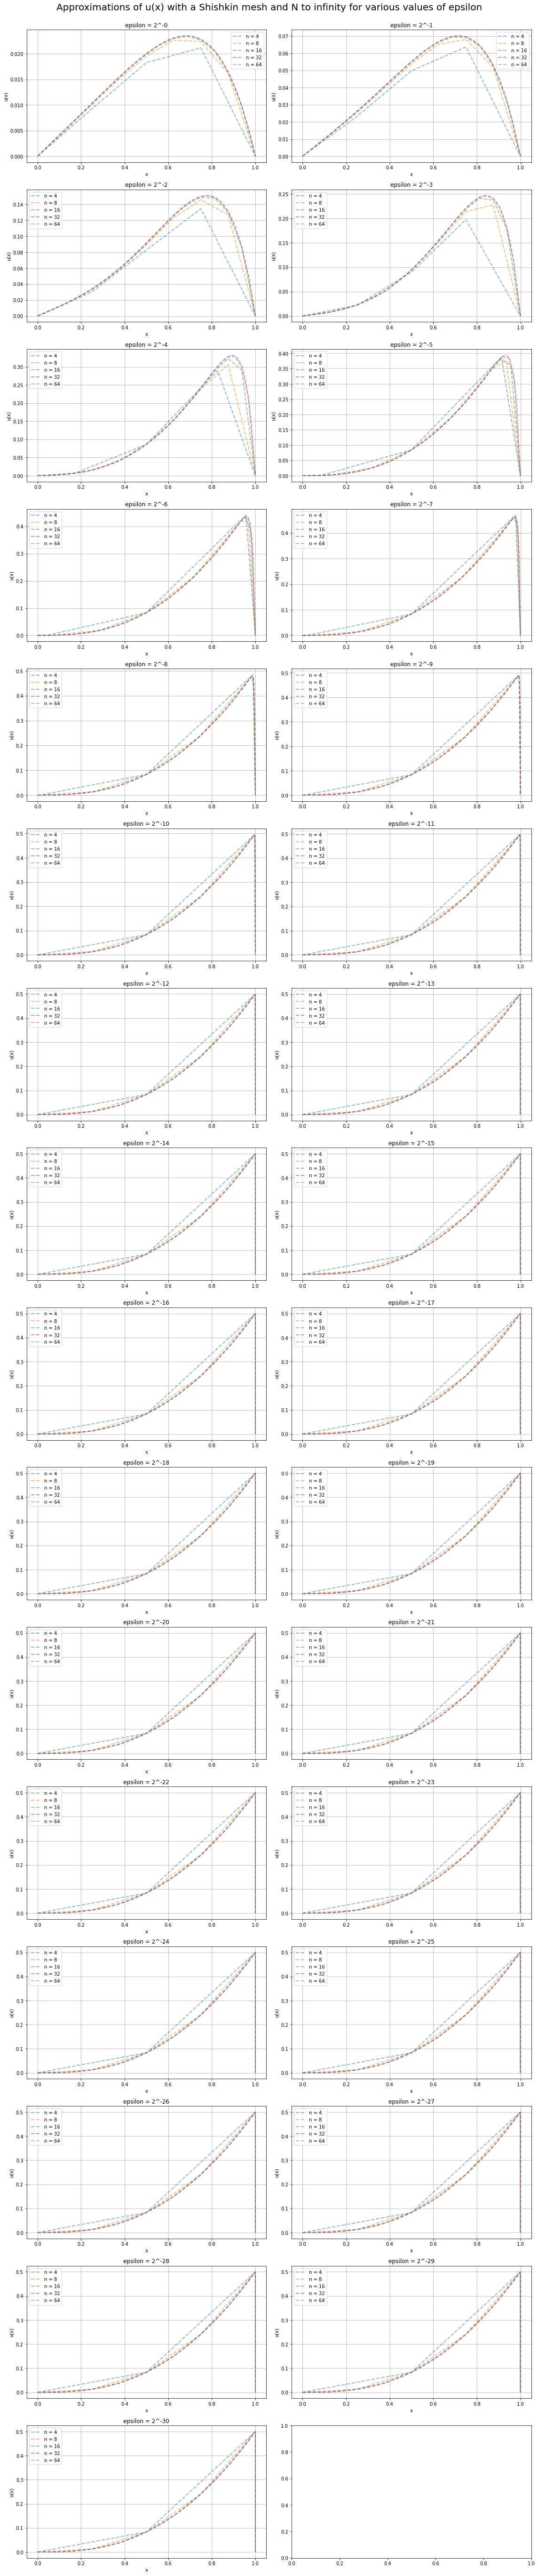

In [26]:
# Plot approximations with epsilon constant, N to infinity, for various values of epsilon

n = np.array([2**k for k in range(2, 7)]) # lower values which are still distinguishable from true solution
eps = np.array([2**(-k) for k in range(0, 31)])

# create one subplot per epsilon
height = 5 * math.ceil(len(eps)/2)
fig, axes = plt.subplots(math.ceil(len(eps)/2), 2, figsize=(16,height), tight_layout=False)
for i, (e, ax) in enumerate(zip(eps, axes.flatten())):
    # get approximations for each n
    solutions = rde.solve_multiple_n(n=n+1, eps=e, shishkin_mesh=True, sigma=2, advanced_solve=False)

    # plot approximations
    for j, (x, u) in enumerate(solutions):
        sns.lineplot(x=x, y=u, linewidth=2, label=f'n = {n[j]}', alpha=0.5, linestyle='--', ax=ax)

    ax.grid()
    ax.set_title(f'epsilon = 2^-{i}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
fig.suptitle(f'Approximations of u(x) with a Shishkin mesh and N to infinity for various values of epsilon', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
if save:
    plt.savefig('../Resultate/test2_shishkin1.png', bbox_inches='tight')
plt.show()

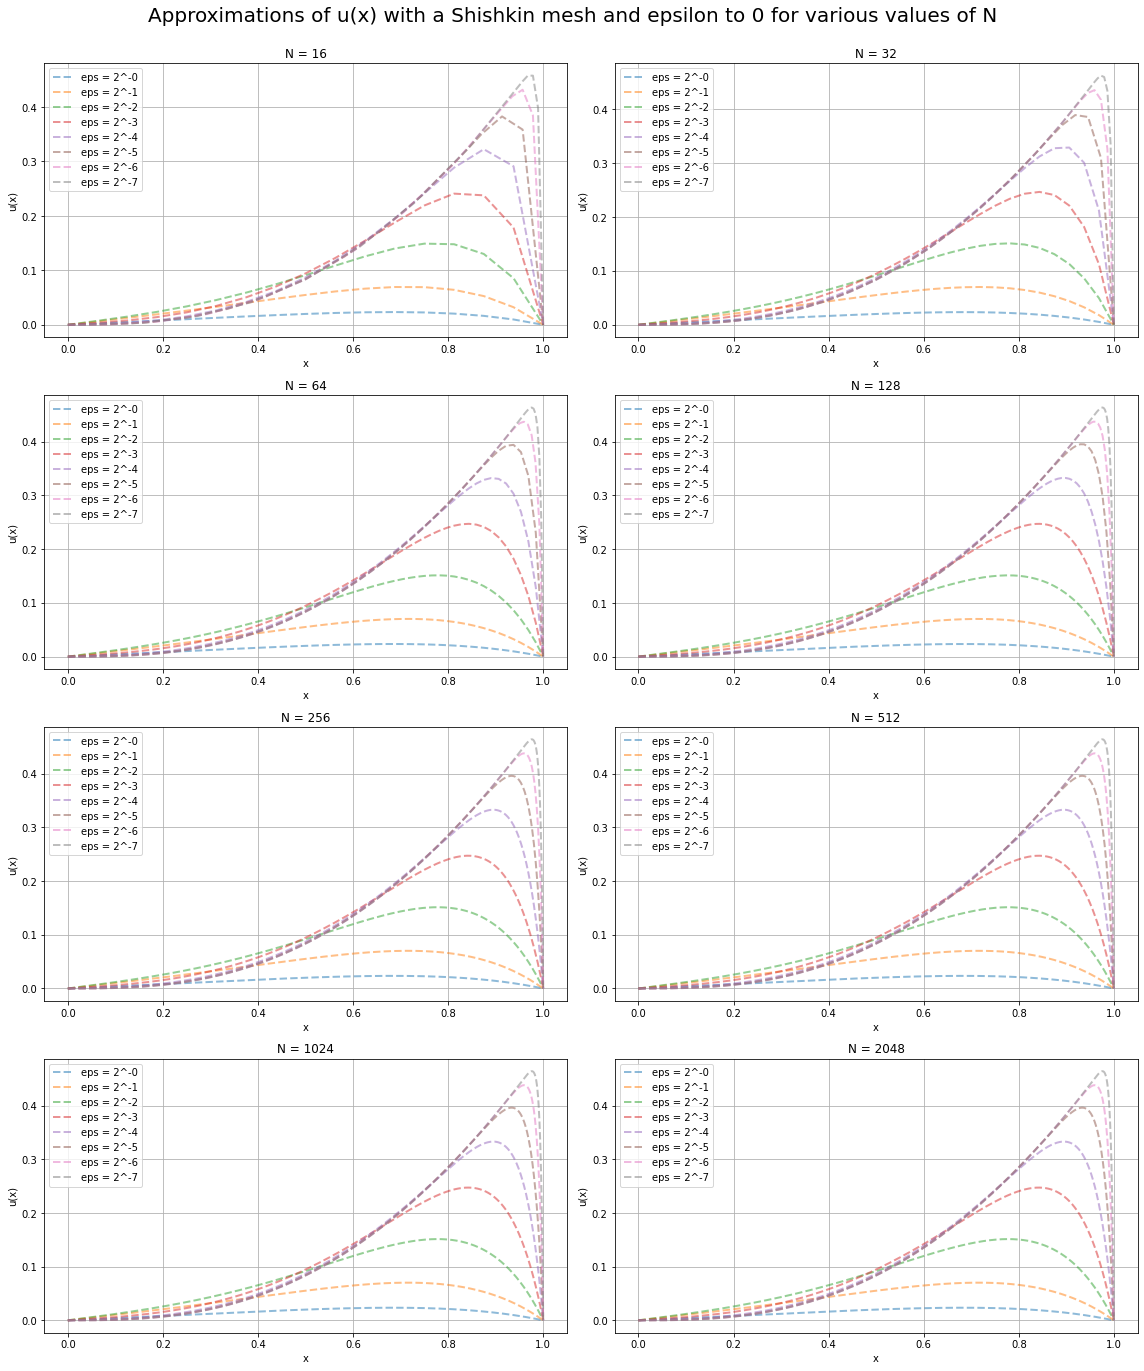

In [27]:
# Plot approximations with N constant, epsilon to 0, for various values of N

n = np.array([2**k for k in range(4, 17)])
eps = np.array([2**(-k) for k in range(0, 8)])

# create one subplot per N
height = 5 * math.ceil(len(eps)/2)
fig, axes = plt.subplots(math.ceil(len(eps)/2), 2, figsize=(16,height), tight_layout=False)
for i, (j, ax) in enumerate(zip(n, axes.flatten())):
    # get approximations for each epsilon
    solutions = rde.solve_multiple_eps(n=j+1, eps=eps, shishkin_mesh=True, sigma=2, advanced_solve=False)

    # plot approximations
    for k, (x, u) in enumerate(solutions):
        sns.lineplot(x=x, y=u, linewidth=2, label=f'eps = 2^-{k}', alpha=0.5, linestyle='--', ax=ax)

    ax.grid()
    ax.legend(loc='upper left')
    ax.set_title(f'N = {j}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
fig.suptitle(f'Approximations of u(x) with a Shishkin mesh and epsilon to 0 for various values of N', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
if save:
    plt.savefig('../Resultate/test2_shishkin2.png', bbox_inches='tight')
plt.show()

### Advanced finite difference scheme <a name="advanced2"></a>

We test our method with the advanced finite difference scheme using a Shishkin mesh with the mesh parameter $\sigma=4$ for each combination of $\varepsilon$ and $N$, $\varepsilon = 2^{-k}$ mit $k= 0, ..., 30$ und $N=2^l$ mit $l = 4, ..., 16$. We report the pointwise maximum absolute error of our approximations over all mesh points using the double mesh principle and plot selected approximations.

In [28]:
# Calculate pointwise maximum abolute errors for each combination of N and epsilon
# NOTE: computationally expensive (~ 4 minutes)

# define values for N and epsilon
n = np.array([2**k for k in range(4, 17)])
eps = np.array([2**(-k) for k in range(0, 31)])

results = {'eps': eps} # store results

# loop over all possible values for N
for i in n:

    errors = [] # to store errors per epsilon
    # get approximations for all epsilons
    for e in eps:
        (x, u_appr), (x_ref, u_ref) = rde.solve(eps=e, n=i+1, shishkin_mesh=True, sigma=4, advanced_solve=True, double_mesh=True)
        u_ref = u_ref[np.where(np.in1d(x_ref, x))[0]] # only compare at mesh points of original approximations
        
        # calculate pointwise maximum absolute error
        error = np.abs(u_appr - u_ref).max()
        errors.append(error)

    results[f'N = {i}'] = errors # store results

df = pd.DataFrame(results)
df = df.set_index('eps')
if save:
    df.to_csv('../Resultate/test2_advanced.csv', index=True)
df

N = 16        N = 32        N = 64       N = 128  \
eps                                                                    
1.000000e+00  5.930828e-08  3.709796e-09  2.320642e-10  1.450541e-11   
5.000000e-01  7.665884e-07  4.799582e-08  3.005188e-09  1.878435e-10   
2.500000e-01  8.550776e-06  5.372297e-07  3.373499e-08  2.109146e-09   
1.250000e-01  1.024101e-04  6.812620e-06  4.277385e-07  2.683686e-08   
6.250000e-02  1.383798e-03  9.217144e-05  6.138917e-06  3.852973e-07   
3.125000e-02  1.005034e-02  1.322245e-03  8.766863e-05  5.844703e-06   
1.562500e-02  1.876306e-02  6.944619e-03  1.293629e-03  8.555225e-05   
7.812500e-03  1.854401e-02  6.874486e-03  1.465441e-03  1.893854e-04   
3.906250e-03  1.843752e-02  6.840222e-03  1.457737e-03  1.882848e-04   
1.953125e-03  1.838502e-02  6.823287e-03  1.453920e-03  1.877388e-04   
9.765625e-04  1.835896e-02  6.814868e-03  1.452020e-03  1.874668e-04   
4.882812e-04  1.834598e-02  6.810671e-03  1.451072e-03  1.873310e-04   
2.441406e-04  1.833949e-02  6.808576e-03  1.450599e-03  1.872632e-04   
1.220703e-04  1.833626e-02  6.807529e-03  1.450362e-03  1.872293e-04   
6.103516e-05  1.833464e-02  6.807005e-03  1.450244e-03  1.872124e-04   
3.051758e-05  1.833383e-02  6.806744e-03  1.450185e-03  1.872039e-04   
1.525879e-05  1.833342e-02  6.806613e-03  1.450155e-03  1.871997e-04   
7.629395e-06  1.833322e-02  6.806548e-03  1.450141e-03  1.871976e-04   
3.814697e-06  1.833312e-02  6.806515e-03  1.450133e-03  1.871965e-04   
1.907349e-06  1.833307e-02  6.806499e-03  1.450129e-03  1.871959e-04   
9.536743e-07  1.833305e-02  6.806490e-03  1.450128e-03  1.871958e-04   
4.768372e-07  1.833303e-02  6.806486e-03  1.450127e-03  1.871954e-04   
2.384186e-07  1.833303e-02  6.806484e-03  1.450126e-03  1.871953e-04   
1.192093e-07  1.833302e-02  6.806483e-03  1.450126e-03  1.871964e-04   
5.960464e-08  1.833302e-02  6.806483e-03  1.450126e-03  1.871966e-04   
2.980232e-08  1.833302e-02  6.806482e-03  1.450127e-03  1.871961e-04   
1.490116e-08  1.833302e-02  6.806482e-03  1.450127e-03  1.871882e-04   
7.450581e-09  1.833302e-02  6.806482e-03  1.450123e-03  1.871860e-04   
3.725290e-09  1.833302e-02  6.806482e-03  1.450120e-03  1.871860e-04   
1.862645e-09  1.833302e-02  6.806482e-03  1.450125e-03  1.871949e-04   
9.313226e-10  1.833302e-02  6.806482e-03  1.450125e-03  1.872128e-04   

                   N = 256       N = 512      N = 1024      N = 2048  \
eps                                                                    
1.000000e+00  9.058171e-13  5.015086e-14  1.318390e-14  7.832970e-14   
5.000000e-01  1.174744e-11  7.284590e-13  2.002565e-14  2.910033e-13   
2.500000e-01  1.318272e-10  8.244877e-12  5.037359e-13  2.529643e-13   
1.250000e-01  1.677798e-09  1.048726e-10  6.563333e-12  4.336809e-13   
6.250000e-02  2.415943e-08  1.510368e-09  9.443119e-11  5.898171e-12   
3.125000e-02  3.667599e-07  2.298763e-08  1.437145e-09  8.983531e-11   
1.562500e-02  5.706961e-06  3.580805e-07  2.243836e-08  1.402945e-09   
7.812500e-03  2.077160e-05  2.082941e-06  1.993519e-07  1.830019e-08   
3.906250e-03  2.065030e-05  2.070848e-06  1.981879e-07  1.819264e-08   
1.953125e-03  2.059012e-05  2.064850e-06  1.976104e-07  1.813932e-08   
9.765625e-04  2.056015e-05  2.061862e-06  1.973220e-07  1.811470e-08   
4.882812e-04  2.054519e-05  2.060372e-06  1.971799e-07  1.810233e-08   
2.441406e-04  2.053772e-05  2.059627e-06  1.971084e-07  1.809612e-08   
1.220703e-04  2.053398e-05  2.059255e-06  1.970660e-07  1.809304e-08   
6.103516e-05  2.053212e-05  2.059068e-06  1.970464e-07  1.809115e-08   
3.051758e-05  2.053119e-05  2.058961e-06  1.970638e-07  1.808979e-08   
1.525879e-05  2.053073e-05  2.058911e-06  1.970717e-07  1.807717e-08   
7.629395e-06  2.053049e-05  2.058939e-06  1.970624e-07  1.783921e-08   
3.814697e-06  2.053032e-05  2.058938e-06  1.968429e-07  1.776046e-08   
1.907349e-06  2.053034e-05  2.058727e-06  1.967297e-07  1.865907e-08   
9.536743e-07  2.053011e-05  2.058683e-06  1.967576e-07  1.8

We also compute the corresponding 'Shishkin' rates of convergence obtained as $\tilde{r}^N = \frac{\ln e^N - \ln e^{2N}}{\ln \left( 2 \ln N \right) - \ln \left( \ln 2 N \right)}$ where $N$ is the number of mesh points and $e$ are the previously reported errors. 

In [29]:
# compute rates of convergence
def denom(x):
    n = int(re.findall(r'\b\d+\b', x.name)[0])
    return x / (np.log(2 * np.log(n)) - np.log(np.log(2*n)))
df_cr = df.apply(np.log).diff(-1, axis=1).apply(denom).round(2)
if save:
    df_cr.to_csv('../Resultate/test2_advanced_convergence.csv', index=True)
df_cr

N = 16  N = 32  N = 64  N = 128  N = 256  N = 512  N = 1024  \
eps                                                                         
1.000000e+00    5.90    5.43    5.14     4.96     5.03     2.27     -2.98   
5.000000e-01    5.90    5.42    5.14     4.95     4.83     6.11     -4.48   
2.500000e-01    5.89    5.42    5.14     4.95     4.82     4.76      1.15   
1.250000e-01    5.77    5.42    5.14     4.95     4.82     4.71      4.54   
6.250000e-02    5.76    5.30    5.14     4.95     4.82     4.72      4.64   
3.125000e-02    4.32    5.31    5.02     4.95     4.81     4.72      4.64   
1.562500e-02    2.11    3.29    5.04     4.84     4.81     4.71      4.64   
7.812500e-03    2.11    3.03    3.80     3.95     4.00     3.99      3.99   
3.906250e-03    2.11    3.03    3.80     3.95     4.00     3.99      3.99   
1.953125e-03    2.11    3.03    3.80     3.95     4.00     3.99      3.99   
9.765625e-04    2.11    3.03    3.80     3.95     4.00     3.99      3.99   
4.882812e-04    2.11    3.03    3.80     3.95     4.00     3.99      3.99   
2.441406e-04    2.11    3.03    3.80     3.95     4.00     3.99      3.99   
1.220703e-04    2.11    3.03    3.80     3.95     4.00     3.99      3.99   
6.103516e-05    2.11    3.03    3.80     3.95     4.00     3.99      3.99   
3.051758e-05    2.11    3.03    3.80     3.95     4.00     3.99      3.99   
1.525879e-05    2.11    3.03    3.80     3.95     4.00     3.99      4.00   
7.629395e-06    2.11    3.03    3.80     3.95     4.00     3.99      4.02   
3.814697e-06    2.11    3.03    3.80     3.95     4.00     3.99      4.02   
1.907349e-06    2.11    3.03    3.80     3.95     4.00     3.99      3.94   
9.536743e-07    2.11    3.03    3.80     3.95     4.00     3.99      3.91   
4.768372e-07    2.11    3.03    3.80     3.95     4.00     3.98      4.23   
2.384186e-07    2.11    3.03    3.80     3.95     4.00     4.00      3.72   
1.192093e-07    2.11    3.03    3.80     3.95     4.00     3.95      3.92   
5.960464e-08    2.11    3.03    3.80     3.95     3.99     4.06      2.83   
2.980232e-08    2.11    3.03    3.80     3.95     4.00     4.10      2.46   
1.490116e-08    2.11    3.03    3.80     3.95     4.01     4.12      2.44   
7.450581e-09    2.11    3.03    3.80     3.95     4.01     4.12     -1.93   
3.725290e-09    2.11    3.03    3.80     3.95     4.00     3.90     -2.41   
1.862645e-09    2.11    3.03    3.80     3.95     3.81     1.13      0.26   
9.313226e-10    2.11    3.03    3.80     3.95     4.08     2.27     -1.25   

              N = 2048  N = 4096  N = 8192  N = 16384  N = 32768  N = 65536  
eps                                                                          
1.000000e+00     -1.99      1.79     -6.04      -3.48      -3.50        NaN  
5.000000e-01     -0.98     -1.84     -3.12      -4.43      -1.93        NaN  
2.500000e-01     -0.55     -2.24      0.64      -4.09      -3.76        NaN  
1.250000e-01      0.43     -0.62     -4.11      -2.75      -4.25        NaN  
6.250000e-02      4.83      0.30     -2.21      -2.78      -4.74        NaN  
3.125000e-02      4.56      4.38     -0.63      -2.01      -4.62        NaN  
1.562500e-02      4.57      4.52      4.38      -1.37      -3.98        NaN  
7.812500e-03      4.26      4.52      4.49       3.63      -2.56        NaN  
3.906250e-03      4.00      4.00      3.91      -0.61      -1.92        NaN  
1.953125e-03      4.00      3.94      3.56      -0.70      -1.73        NaN  
9.765625e-04      4.00      3.94      3.44      -2.06      -0.34        NaN  
4.882812e-04      4.00      4.09      3.23      -2.22      -2.10        NaN  
2.441406e-04      3.99      3.85      0.05      -0.50      -0.33        NaN  
1.220703e-04      4.02      4.42      0.08      -1.90      -1.48        NaN  
6.103516e-05      4.03      3.86     -1.73      -0.84      -1.00        NaN  
3.051758e-05      4.02      2.00     -0.44      -1.31      -0.27        NaN  
1.525879e-05      3.80      2.05     -1.26      -1.23       0.51    

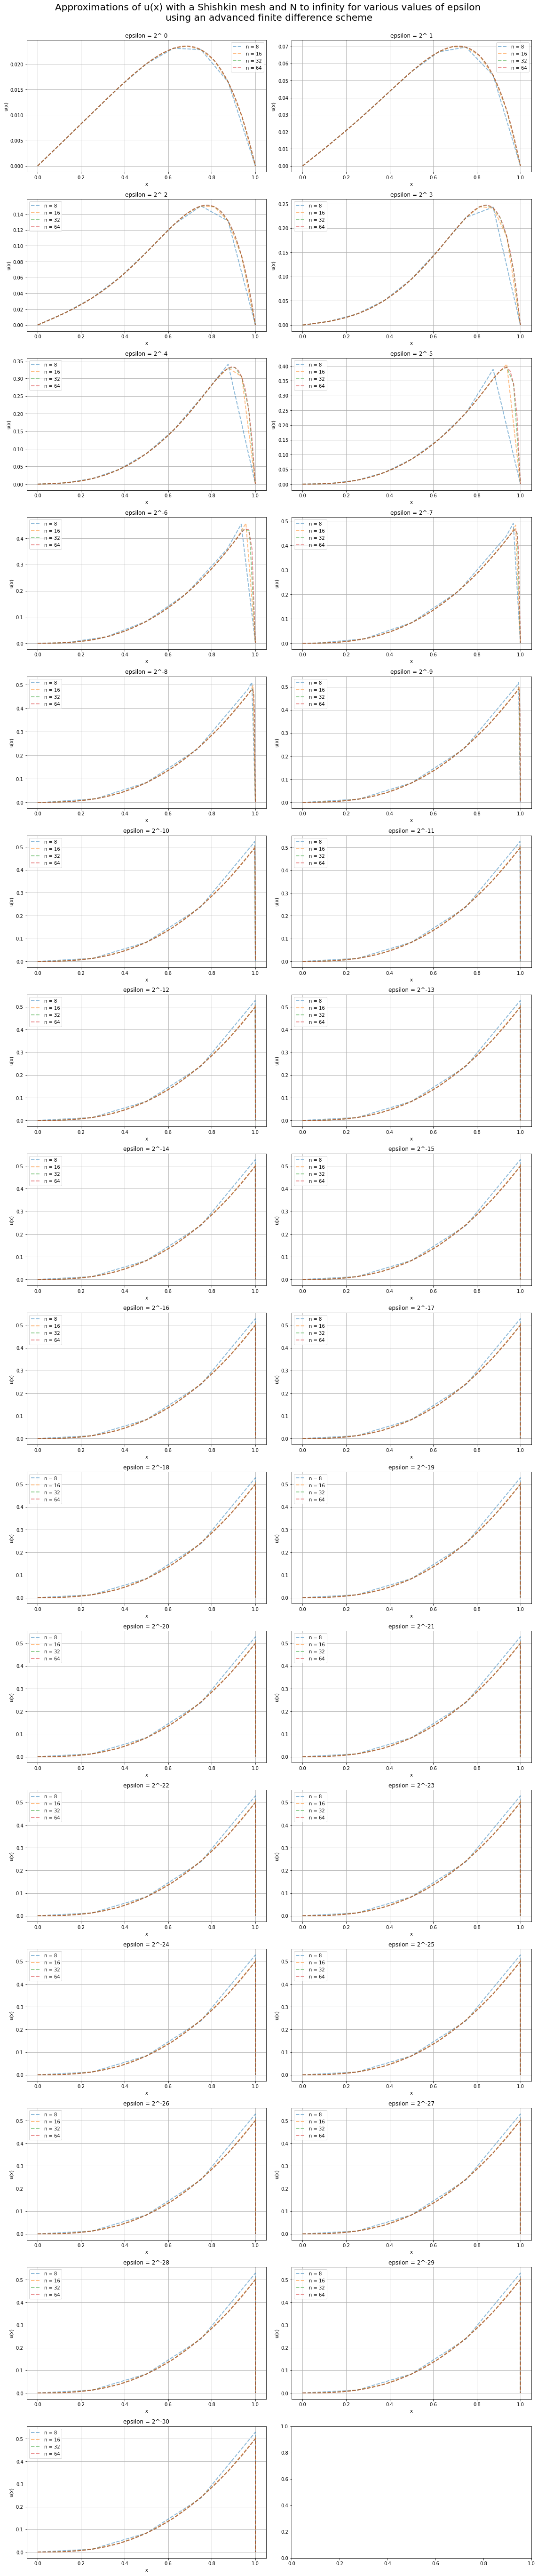

In [30]:
# Plot approximations with epsilon constant, N to infinity, for various values of epsilon

n = np.array([2**k for k in range(3, 7)]) # lower values which are still distinguishable from true solution
eps = np.array([2**(-k) for k in range(0, 31)])

# create one subplot per epsilon
height = 5 * math.ceil(len(eps)/2)
fig, axes = plt.subplots(math.ceil(len(eps)/2), 2, figsize=(16,height), tight_layout=False)
for i, (e, ax) in enumerate(zip(eps, axes.flatten())):
    # get approximations for each n
    solutions = rde.solve_multiple_n(n=n+1, eps=e, shishkin_mesh=True, sigma=4, advanced_solve=True)

    # plot approximations
    for j, (x, u) in enumerate(solutions):
        sns.lineplot(x=x, y=u, linewidth=2, label=f'n = {n[j]}', alpha=0.5, linestyle='--', ax=ax)

    ax.grid()
    ax.set_title(f'epsilon = 2^-{i}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
fig.suptitle(f'Approximations of u(x) with a Shishkin mesh and N to infinity for various values of epsilon \nusing an advanced finite difference scheme', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
if save:
    plt.savefig('../Resultate/test2_advanced1.png', bbox_inches='tight')
plt.show()

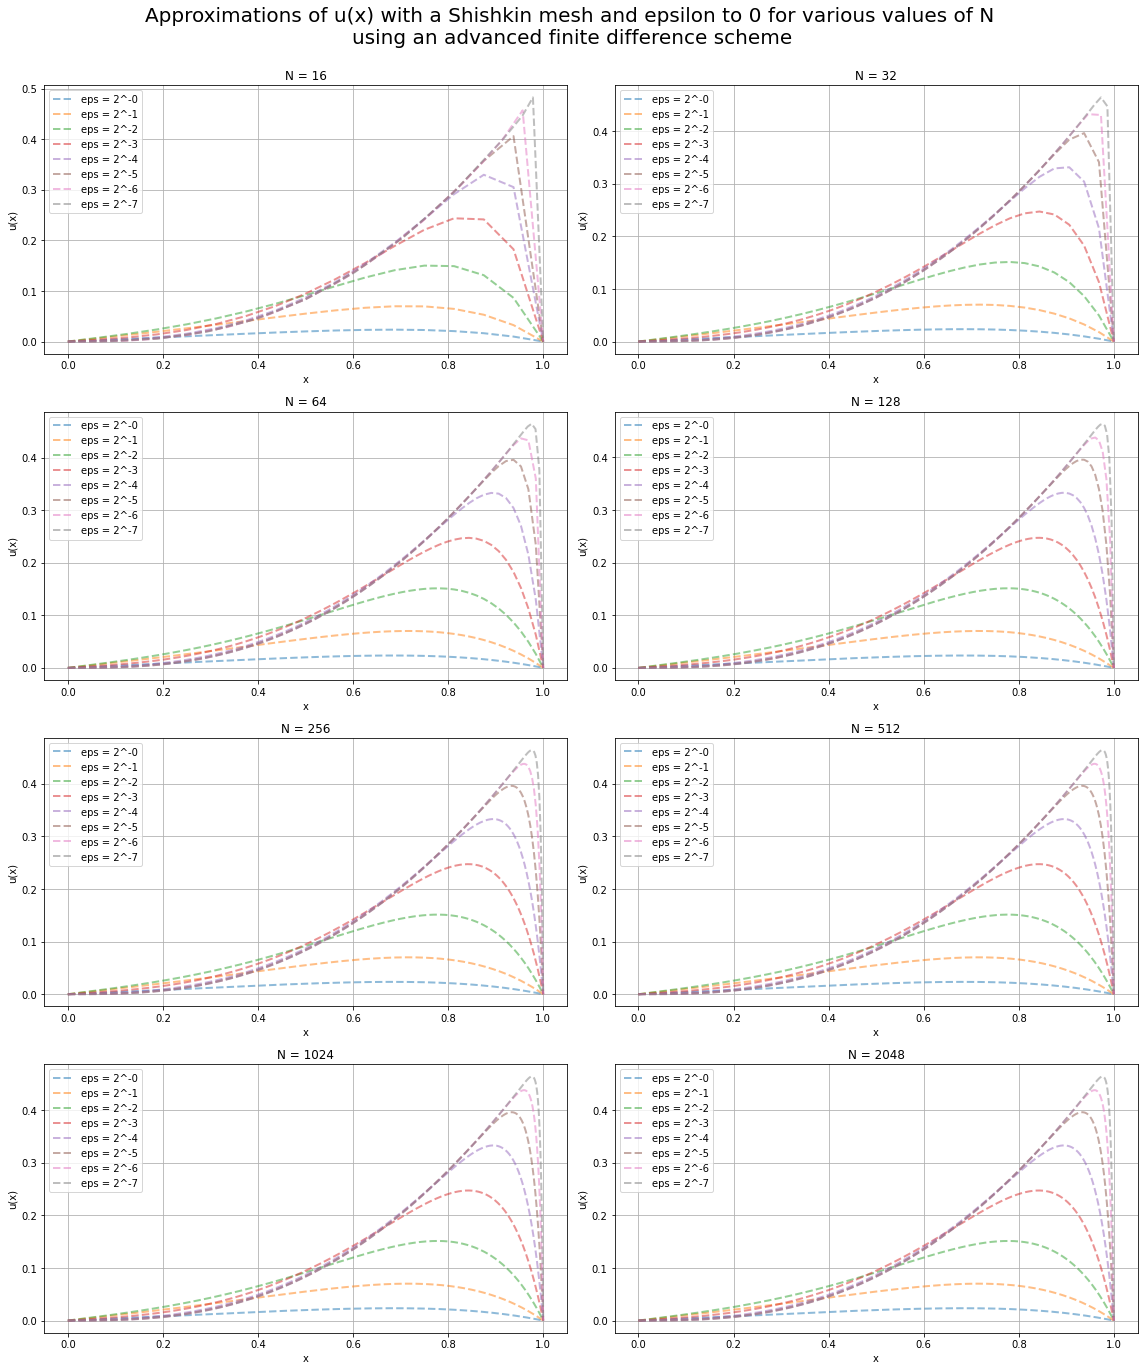

In [31]:
# Plot approximations with N constant, epsilon to 0, for various values of N

n = np.array([2**k for k in range(4, 17)])
eps = np.array([2**(-k) for k in range(0, 8)])

# create one subplot per N
height = 5 * math.ceil(len(eps)/2)
fig, axes = plt.subplots(math.ceil(len(eps)/2), 2, figsize=(16,height), tight_layout=False)
for i, (j, ax) in enumerate(zip(n, axes.flatten())):
    # get approximations for each epsilon
    solutions = rde.solve_multiple_eps(n=j+1, eps=eps, shishkin_mesh=True, sigma=4, advanced_solve=True)

    # plot approximations
    for k, (x, u) in enumerate(solutions):
        sns.lineplot(x=x, y=u, linewidth=2, label=f'eps = 2^-{k}', alpha=0.5, linestyle='--', ax=ax)

    ax.grid()
    ax.legend(loc='upper left')
    ax.set_title(f'N = {j}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
fig.suptitle(f'Approximations of u(x) with a Shishkin mesh and epsilon to 0 for various values of N \nusing an advanced finite difference scheme', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
if save:
    plt.savefig('../Resultate/test2_advanced2.png', bbox_inches='tight')
plt.show()

### Comparison <a name="comparison2"></a>

Previously reported errors may suggest that a Shishkin mesh and advanced finite difference methods may lead to no improvement over the base solution. However, this is because the Shishkin mesh shifts mesh points into the boundary layers, where function values change more abruptly which generally yields larger errors. Maximum absolute errors are commonly obtained in these boundary layers, whereas most mesh points of a uniform mesh are not inside boundary layers (for low values of $N$). Here, we visually compare the resulting approximations to show the improvements for selected combinations of $N$ and $\varepsilon$.

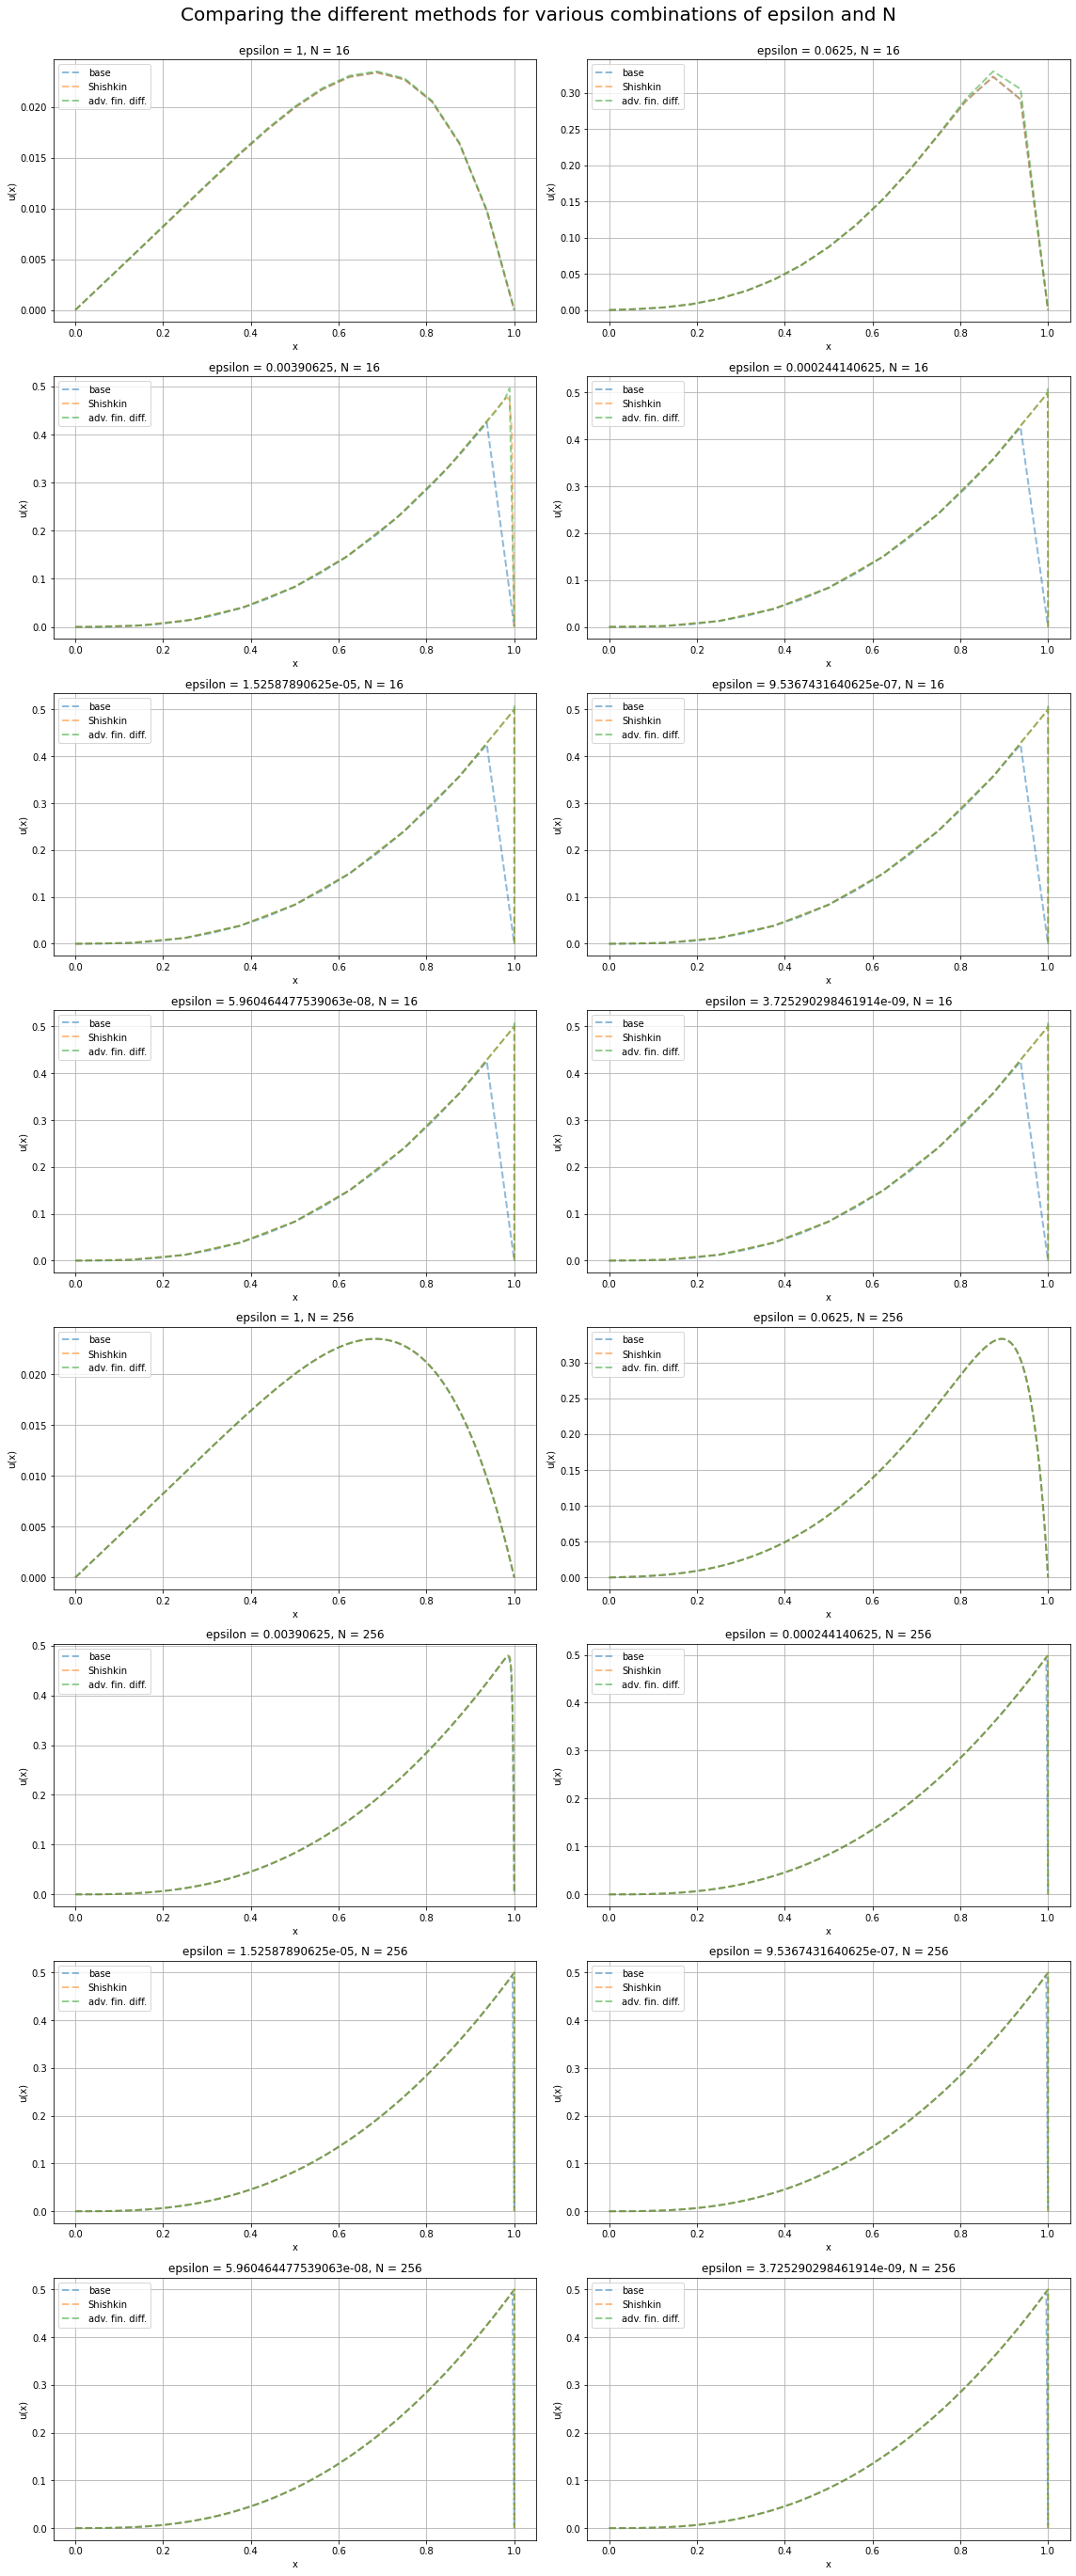

In [32]:
# define combinations of N and epsilon to depict
params = [(4, 0), (4, 4), (4, 8), (4, 12), (4, 16), (4, 20), (4, 24), (4, 28), (8, 0), (8, 4), (8, 8), (8, 12), (8, 16), (8, 20), (8, 24), (8, 28)]
params = [(2**l + 1, 2**(-k)) for l, k in params]

# create one subplot per epsilon
height = 5 * math.ceil(len(params)/2)
fig, axes = plt.subplots(math.ceil(len(params)/2), 2, figsize=(16,height), tight_layout=False)
for i, ((n, eps), ax) in enumerate(zip(params, axes.flatten())):
    x_base, u_base = rde.solve(eps=eps, n=n, shishkin_mesh=False, sigma=2, 
                                advanced_solve=False, verbose=False)
    x_opt, u_opt = rde.solve(eps=eps, n=n, shishkin_mesh=True, sigma=2, 
                        advanced_solve=False, verbose=False)
    x_full, u_full = rde.solve(eps=eps, n=n, shishkin_mesh=True, sigma=4, 
                        advanced_solve=True, verbose=False)
    solutions = [(x_base, u_base), (x_opt, u_opt), (x_full, u_full)]
    titles = {0: 'base', 1: 'Shishkin', 2: 'adv. fin. diff.'}

    for i, (x, u) in enumerate(solutions):
        sns.lineplot(x=x, y=u, linewidth=2, label=titles[i], alpha=0.5, ax=ax, linestyle='--')

    ax.grid()
    ax.legend(loc='upper left')
    ax.set_title(f'epsilon = {eps}, N = {n-1}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')

fig.suptitle(f'Comparing the different methods for various combinations of epsilon and N', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
if save:
    plt.savefig('../Resultate/test2_comparison.png', bbox_inches='tight')
plt.show()

## Reproduction: $- \epsilon^2 u''(x) + (1+x^2+\cos(x)) u(x) = x^{9/2}+ \sin(x)$ <a name="reproduction"></a>

Here, we reproduce the results from [1] for $- \epsilon^2 u''(x) + (1+x^2+\cos(x)) u(x) = x^{9/2}+ \sin(x), \ u(0)=u(1)=0$ using a shishkin mesh and the advanced finite difference scheme.

[1] Linß, T. Robust convergence of a compact fourth-order finite difference scheme for reaction–diffusion problems. Numer. Math. 111, 239–249 (2008). https://doi.org/10.1007/s00211-008-0184-4

In [33]:
# create class instance
f = lambda x: x**(9/2) + np.sin(x)
c = lambda x: 1 + x**2 + np.cos(x)
rde = ReactionDiffusionEquation(f=f, c=c)

In [36]:
# Calculate pointwise maximum abolute errors for each combination of N and epsilon

# define values for N and epsilon
n = np.array([3*2**k for k in range(7, 17)])
eps = np.array([10**(-4*k) for k in range(1, 2)])

results = {'eps': eps} # store results

# loop over all possible values for N
for ind, i in enumerate(n):

    errors = [] # to store errors per epsilon
    # get approximations for all epsilons
    for e in eps:
        (x, u_appr), (x_ref, u_ref) = rde.solve(eps=e, n=i+1, shishkin_mesh=True, sigma=4, advanced_solve=True, double_mesh=True)
        u_ref = u_ref[np.where(np.in1d(x_ref, x))[0]] # only compare at mesh points of original approximations
        
        # calculate pointwise maximum absolute error
        error = np.abs(u_appr - u_ref).max()
        errors.append(error)

    results[f'N = 3 x 2^{7+ind}'] = errors # store results

df = pd.DataFrame(results)
df = df.set_index('eps')
if save:
    df.to_csv('../Resultate/reproduction.csv', index=True)
df

N = 3 x 2^7   N = 3 x 2^8   N = 3 x 2^9  N = 3 x 2^10  N = 3 x 2^11  \
eps                                                                           
0.0001     0.000003  3.074492e-07  2.869502e-08  2.443315e-09  1.038151e-09   

        N = 3 x 2^12  N = 3 x 2^13  N = 3 x 2^14  N = 3 x 2^15  N = 3 x 2^16  
eps                                                                           
0.0001  1.772589e-09  4.867877e-09  9.038881e-09  1.008140e-08  1.796370e-08

Initially, our results our consistent with the results from [1], with minor differences possibly being caused by rounding errors. However, when reaching a certain order of magnitude (for $\varepsilon=10^{-4}$ for $N \geq 3*2^{11}$), the errors collapse. This collapse is also visible for the rates of convergence below.

We also compute the corresponding 'Shishkin' rates of convergence obtained as $\tilde{r}^N = \frac{\ln e^N - \ln e^{2N}}{\ln \left( 2 \ln N \right) - \ln \left( \ln 2 N \right)}$ where $N$ is the number of mesh points and $e$ are the previously reported errors. 

In [37]:
# compute rates of convergence
mapper = {k: f'N = {v}' for k, v in zip(df.columns, n)}
df = df.rename(columns=mapper)
def denom(x):
    n = int(re.findall(r'\b\d+\b', x.name)[0])
    return x / (np.log(2 * np.log(n)) - np.log(np.log(2*n)))
df_cr = df.apply(np.log).diff(-1, axis=1).apply(denom).round(2)

mapper = {v: k for k, v in mapper.items()}
df_cr = df_cr.rename(columns=mapper)
if save:
    df_cr.to_csv('../Resultate/reproduction_convergence.csv', index=True)
df_cr

N = 3 x 2^7  N = 3 x 2^8  N = 3 x 2^9  N = 3 x 2^10  N = 3 x 2^11  \
eps                                                                         
0.0001         3.99         3.99         4.09           1.4         -0.87   

        N = 3 x 2^12  N = 3 x 2^13  N = 3 x 2^14  N = 3 x 2^15  N = 3 x 2^16  
eps                                                                           
0.0001         -1.62         -0.99         -0.17         -0.91           NaN